### Analyzing Initial BCI Runs

In [181]:
from scipy.stats import qmc
import numpy as np
import xarray as xr
import csv
import pandas as pd
import os
import netCDF4 as nc4
import sys
from tempfile import TemporaryFile                                                                                                                                 
import argparse                                                                                                                                                     
import shutil                                                                                                                                                       
import tempfile 
import random
import math
import scipy.optimize as opt

import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from matplotlib import cm
import matplotlib.colors as mcolors
from matplotlib.colors import Normalize
from matplotlib.colors import BoundaryNorm

import functions_py.fates_xarray_functions as fa

dark = cm.get_cmap('Paired', 12)
colormap = dark(range(12))
colormap[10] = colormap[11]

def clllpf_to_cn_lf_by_pft(clllpf_var, dataset, dataset2):
    """function to reshape a fates multiplexed canopy layer, leaf layer and pft-indexed variable to one indexed by canopy layer leaf layer and pft
    first argument should be an xarray DataArray that has the FATES CLLLPF dimension
    second argument should be an xarray Dataset that has the FATES CLLL dimensions
    (possibly the dataset encompassing the dataarray being transformed)
    returns an Xarray DataArray with the cnlf  (CLLL) and pft dimensions disentangled"""
    n_cnlf = len(dataset.fates_levcnlf)
    ds_out = (clllpf_var.rolling(fates_levcnlfpf=n_cnlf, center=False)
            .construct("fates_levcnlf")
            .isel(fates_levcnlfpf=slice(n_cnlf-1, None, n_cnlf))
            .rename({'fates_levcnlfpf':'fates_levpft'})
            .assign_coords({'fates_levcnlf':dataset.fates_levcnlf})
            .assign_coords({'fates_levpft':dataset.fates_levpft}))
    ds_out.attrs['long_name'] = clllpf_var.attrs['long_name']
    ds_out.attrs['units'] = clllpf_var.attrs['units']
    
    # now create a new dimension - leaf layers - and disentangle canopy layers and leaf layers
    n_levleaf = len(dataset2.fates_levleaf)
    ds_out2 = (ds_out.rolling(fates_levcnlf=n_levleaf, center=False)
               .construct("fates_levleaf")
               .isel(fates_levcnlf=slice(n_levleaf-1, None, n_levleaf))
               .rename({'fates_levcnlf':'fates_levcan'})
               .assign_coords({'fates_levleaf':dataset2.fates_levleaf})
               .assign_coords({'fates_levcan':dataset.fates_levcan}))
    ds_out2.attrs['long_name'] = ds_out.attrs['long_name']
    ds_out2.attrs['units'] = ds_out.attrs['units']
    
    return(ds_out2)

/var/folders/30/fzgs75l559g5v3hbrhqnl3kr0000gq/T/ipykernel_3321/1483484542.py:26: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  dark = cm.get_cmap('Paired', 12)


In [216]:
#example fates run
fates = '/Users/sharmiladey/Desktop/bci_p0.Eb645be3aa2-F46cf01a4.2023-05-10.elm.h0.example_run.nc'
fates = xr.open_dataset(fates, decode_times=False)

#time = (fates.variables['time'].isel(time=slice(25,100)) / 365) - 10

#piponiot data https://onlinelibrary.wiley.com/doi/abs/10.1111/nph.17995
pip = pd.read_csv('/Users/sharmiladey/Downloads/Piponiot_2022_NewPhyt_AGB_AWP_AWM_standard_size_class.csv')
pip = pip[(pip.site == "BCI")]
#aboveground biomass
pip_agb = pip[(pip.variable == "AGB")]
#aboveground woody productivity
pip_awp = pip[(pip.variable == "AWP")]
#aboveground woody mortality
pip_awm = pip[(pip.variable == "AWM")]

#julien's data
lamour = pd.read_csv("/Users/sharmiladey/Desktop/Data_Vertical_Profiles.csv")
lamour = lamour[(lamour.Life_form != "LIANA") & (lamour.Life_form != "HEMIEPIPHYTIC VINE") & (lamour.Life_form != "HERB") & (lamour.Life_form) & (lamour.LAI) & (lamour.Rdark25) & (lamour.Vcmax25)]
lamour =  lamour.dropna(subset=['LAI', 'Rdark25'])

#fates run at bci with 1 pft
bci1 = '/Users/sharmiladey/Desktop/bci_trendy_dben_1pft.Eb645be3aa2-F14b1791a.2023-06-19.elm.h0.fullrun.nc'
bci1 = xr.open_dataset(bci1, decode_times=False)
bci1time = (bci1.variables['time'] / 12)
bci1time = bci1time.isel(time=slice(250,300))

#fates run at bci with 2 pfts
bci2 = '/Users/sharmiladey/Desktop/bci_trendy_dben_2pfts.Eb645be3aa2-F14b1791a.2023-06-20.elm.h0.sofar.nc'
bci2 = xr.open_dataset(bci2, decode_times=False)
bci2time = (bci2.variables['time'] / 12)
bci2time = bci2time.isel(time=slice(250,300))

#fates ensemble run at bci (missing some variables) run for 301 years
bcie = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_scaling.Eb645be3aa2-Fe445bf49.2023-06-23.h0.ensemble.sofar.nc'
bcie = xr.open_dataset(bcie, decode_times=False)
bcietime = bcie.variables['time'] / 365

#fates ensemble run at bci run for ___ years
bcie2 = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_scaling.Eb645be3aa2-Fe445bf49.2023-06-27.h0.ensemble.sofar.nc'
bcie2 = xr.open_dataset(bcie2, decode_times=False)
bcie2time = bcie2.variables['time'] / 365

#2pfts, 300 years
#bcie3 = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_scaling.Eb645be3aa2-F7501de66.2023-06-29.h0.ensemble.sofar.nc'
#2pfts, 400 years
#bcie3 = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_scaling.Eb645be3aa2-F8e9cf1be.2023-06-30.h0.ensemble.sofar.nc'
#2pfts, 500 years, 3 leaf layers, more pft coexistence
#bcie3 = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_scaling.Eb645be3aa2-Ff47577fa.2023-07-03.h0.ensemble.sofar.nc'
#2pfts, 50 years, 3 leaf layers 
#bcie3 = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_scaling.Eb645be3aa2-Ff47577fa.2023-07-05.h0.ensemble.sofar.nc'
#-------
#bcie3 = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_scaling_slatop1.5.Eb645be3aa2-Ff47577fa.2023-07-05.h0.ensemble.sofar.nc'
#first run with all 8 models! has a fates bug tho
#bcie3 = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_vcmax_scaling.Eb645be3aa2-F00b6500c.2023-07-14.h0.ensemble.sofar.nc'
bcie3 = '/Users/sharmiladey/Desktop/bci_ensemble_2pfts_vert_vcmax_scaling.Eb645be3aa2-F2cdbefb8.2023-07-17.h0.ensemble.sofar.nc'
bcie3 = xr.open_dataset(bcie3, decode_times=False)
bcie3time = bcie3.variables['time'] / 365

print(bcie3.data_vars)
#print(bcie3time)

Data variables:
    fates_scmap_levscag               (record, fates_levscag) int32 ...
    fates_agmap_levscag               (record, fates_levscag) int32 ...
    fates_pftmap_levscpf              (record, fates_levscpf) int32 ...
    fates_scmap_levscpf               (record, fates_levscpf) int32 ...
    fates_pftmap_levcapf              (record, fates_levcapf) int32 ...
    fates_camap_levcapf               (record, fates_levcapf) int32 ...
    fates_levleaf                     (record, lndgrid) int32 ...
    fates_canmap_levcnlf              (record, fates_levcnlf) int32 ...
    fates_lfmap_levcnlf               (record, fates_levcnlf) int32 ...
    fates_canmap_levcnlfpf            (record, fates_levcnlfpf) int32 ...
    fates_lfmap_levcnlfpf             (record, fates_levcnlfpf) int32 ...
    fates_pftmap_levcnlfpf            (record, fates_levcnlfpf) int32 ...
    fates_scmap_levscagpft            (record, fates_levscagpf) int32 ...
    fates_agmap_levscagpft            (record,

In [243]:
paired = cm.get_cmap('Paired', 10)
colormap = paired(range(10))

#f1ax0.plot(cumulative_lai, nscaler_lloyd, color=colormap[0], label='Lloyd')
#f1ax0.plot(cumulative_lai, nscaler_lloyd, color=colormap[3], label='Atkin')
#f1ax0.plot(cumulative_lai, nscaler_lamour, color=colormap[5], label='Lamour')
#f1ax0.plot(cumulative_lai, nscaler_lloyd, color=colormap[2], label='Ryan')

set3 = cm.get_cmap('Dark2', 11)
colormap2 = set3(range(11))

print(bcie3time)

<xarray.Variable (time: 241)>
array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  26.,  27.,  28.,  29.,  30.,  31.,  32.,
        33.,  34.,  35.,  36.,  37.,  38.,  39.,  40.,  41.,  42.,  43.,
        44.,  45.,  46.,  47.,  48.,  49.,  50.,  51.,  52.,  53.,  54.,
        55.,  56.,  57.,  58.,  59.,  60.,  61.,  62.,  63.,  64.,  65.,
        66.,  67.,  68.,  69.,  70.,  71.,  72.,  73.,  74.,  75.,  76.,
        77.,  78.,  79.,  80.,  81.,  82.,  83.,  84.,  85.,  86.,  87.,
        88.,  89.,  90.,  91.,  92.,  93.,  94.,  95.,  96.,  97.,  98.,
        99., 100., 101., 102., 103., 104., 105., 106., 107., 108., 109.,
       110., 111., 112., 113., 114., 115., 116., 117., 118., 119., 120.,
       121., 122., 123., 124., 125., 126., 127., 128., 129., 130., 131.,
       132., 133., 134., 135., 136., 137., 138., 139., 140., 141., 142.,
       143., 144., 14

/var/folders/30/fzgs75l559g5v3hbrhqnl3kr0000gq/T/ipykernel_3321/2967792990.py:1: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  paired = cm.get_cmap('Paired', 10)
/var/folders/30/fzgs75l559g5v3hbrhqnl3kr0000gq/T/ipykernel_3321/2967792990.py:9: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  set3 = cm.get_cmap('Dark2', 11)


In [218]:
def func(x,a, b):
    return (a + b * x) * (1.7560 + 0.2061 * (0.033/0.012) + -0.0402 * max(0, (298.15 - 273.15)))
optimizedParameters, pcov = opt.curve_fit(func, lamour['LAI'], lamour['Rdark25'])

print(optimizedParameters) 

[ 0.76775865 -0.07549542]


### Comparing models

Text(0.5, 0, 'Cumulative LAI')

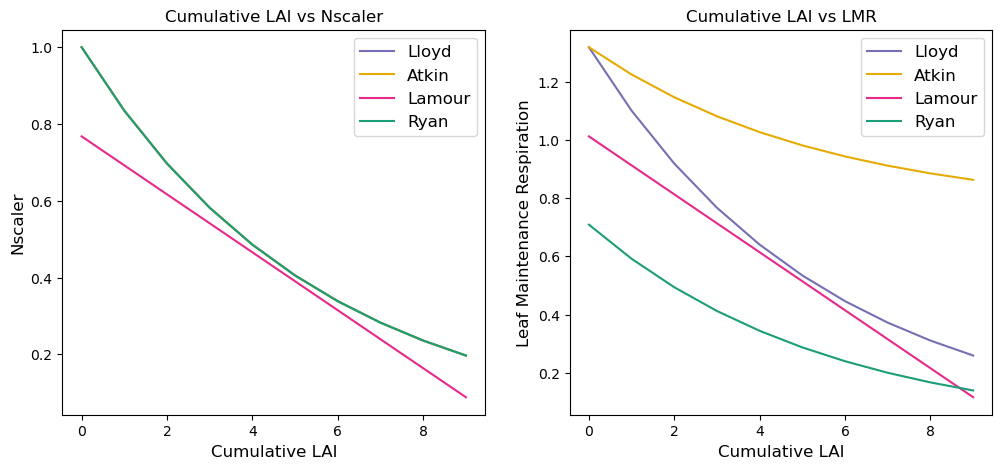

In [173]:
#redoing the respiration curves
#code is from FatesPlantRespPhotosynthMod.F90 and FatesAllometryMod.F90

#constants
vcmax25top = 74.6
#lnc_top from FatesPlantRespPhotosynthMod.F90 - using a constant for everything
lnc_top = 0.033 / 0.012  # g N leaf / slatop 
umolC_to_kgC = 12.0e-9
g_per_kg = 1000.0
tfrz = 273.15
veg_tempk = 298.15
maintresp_leaf_ryan1991_baserate = 2.525e-06
lmrha = 46390
lmrhd = 150650
lmrse = 490
lmrc = 1.15912391
r0 = 1.756
r1 = 0.2061
r2 = -0.0402
tgrowth = 298.15
rgas = 8314.4598

#Original LAI vs Nscaler (Lloyd)
#exp calculated with decay_coeff_kn in FatesAllometryMod.F90 using vcmax25top = 50
exp_lloyd = (0.00963 * vcmax25top - 2.43)
kn_lloyd = pow(math.e, exp_lloyd)
#cumulative lai is a string of numbers from 1 to 10
cumulative_lai = np.array(range(0,10))
#nscaler calculated from FatesPlantRespPhotosynthMod.F90
nscaler_lloyd = math.e ** (-kn_lloyd * cumulative_lai)

#from FatesPlantRespPhotosynthMod.F90 (tgrowth = 289.15, veg_tempk = 298.15)
r_t_ref_lloyd = nscaler_lloyd * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz)))
lmr_lloyd = r_t_ref_lloyd * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 

#---------------------
#LAI vs Nscaler concave down
#exponent changed to look concave down
nscaler_negexp = 0.05 * -math.e**(cumulative_lai * 0.3) + 1.05

r_t_ref_negexp = nscaler_negexp * (r0 + r1 * lnc_top + r2 * max(0.0, (tgrowth - tfrz)))
lmr_negexp = r_t_ref_negexp * math.e**(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2))

#---------------------
#LAI vs Nscaler Atkin
#same nscaler for atkin and original (only respiration calculation is different)
lnc = lnc_top * nscaler_lloyd

r_t_ref_atkin = r0 + r1 * lnc + r2 * max(0, (tgrowth - tfrz))
lmr_atkin = r_t_ref_atkin * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 

#---------------------
#Lamour 
nscaler_lamour = 0.76775866 + (-0.07549542 * cumulative_lai)                                    

r_t_ref_lamour = nscaler_lamour * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz)))  
lmr_lamour = r_t_ref_lamour * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2))

#---------------------
#Ryan

def ft1_f (tl, ha):
    ans = np.exp( ha / (rgas*1e-3*(tfrz+25.)) * (1. - (tfrz+25.)/tl) ) 
    return(ans)

def fth_f(tl, hd, se, scaleFactor):
    ans = scaleFactor / ( 1. + np.exp( (-hd+se*tl) / (rgas*1.e-3*tl) ) )   
    return(ans)

lmr25top = maintresp_leaf_ryan1991_baserate * (1.5 ** ((25 - 20)/10))
lmr25top = lmr25top * lnc_top / (umolC_to_kgC * g_per_kg)

lmr25 = lmr25top * nscaler_lloyd

lmr_ryan = lmr25 * ft1_f(veg_tempk, lmrha) * fth_f(veg_tempk, lmrhd, lmrse, lmrc)

#plot
fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

f1ax0.plot(cumulative_lai, nscaler_lloyd, color=colormap2[3], label='Lloyd')
f1ax0.plot(cumulative_lai, nscaler_lloyd, color=colormap2[7], label='Atkin')
f1ax0.plot(cumulative_lai, nscaler_lamour, color=colormap2[4], label='Lamour')
f1ax0.plot(cumulative_lai, nscaler_lloyd, color=colormap2[0], label='Ryan')
f1ax0.legend(prop={'size':12})
f1ax0.set_title(r'Cumulative LAI vs Nscaler', fontsize=12)
f1ax0.set_ylabel(r'Nscaler', fontsize=12)
f1ax0.set_xlabel(r'Cumulative LAI', fontsize=12)

f1ax1.plot(cumulative_lai, lmr_lloyd, color=colormap2[3], label='Lloyd')
f1ax1.plot(cumulative_lai, lmr_atkin, color=colormap2[7], label='Atkin')
f1ax1.plot(cumulative_lai, lmr_lamour, color=colormap2[4], label='Lamour')
f1ax1.plot(cumulative_lai, lmr_ryan, color=colormap2[0], label='Ryan')
f1ax1.legend(prop={'size':12})
f1ax1.set_title(r'Cumulative LAI vs LMR', fontsize=12)
f1ax1.set_ylabel(r'Leaf Maintenance Respiration', fontsize=12)
f1ax1.set_xlabel(r'Cumulative LAI', fontsize=12)

#####PREDICTION: concave down wide or lamour schemes are going to be the best fit because 
#####they are the most dissimilar from the original. These schemes will result in the most biomass.

In [174]:
atkin_offset = lmr_atkin[0] - lmr_lamour[0]
lloyd_offset = lmr_lloyd[0] - lmr_lamour[0]
ryan_offset = lmr_ryan[0] - lmr_lamour[0]

Text(0.5, 0, 'Cumulative LAI')

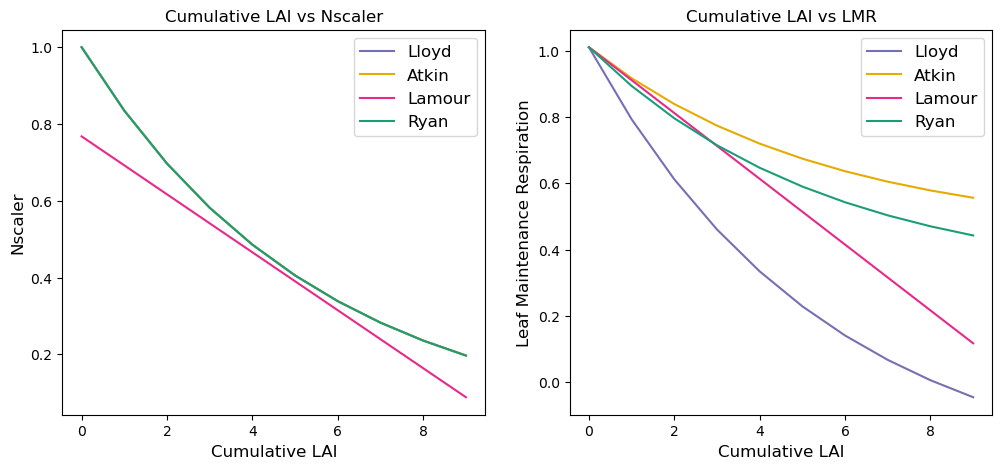

In [175]:
#redoing the respiration curves
#code is from FatesPlantRespPhotosynthMod.F90 and FatesAllometryMod.F90

#Original LAI vs Nscaler (Lloyd)
#from FatesPlantRespPhotosynthMod.F90 (tgrowth = 289.15, veg_tempk = 298.15)
r_t_ref_lloyd = nscaler_lloyd * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz))) - lloyd_offset
lmr_lloyd = r_t_ref_lloyd * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 

#---------------------
#LAI vs Nscaler concave down
#exponent changed to look concave down
r_t_ref_negexp = nscaler_negexp * (r0 + r1 * lnc_top + r2 * max(0.0, (tgrowth - tfrz)))
lmr_negexp = r_t_ref_negexp * math.e**(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2))

#---------------------
#LAI vs Nscaler Atkin
#same nscaler for atkin and original (only respiration calculation is different)
r_t_ref_atkin = r0 + r1 * lnc + r2 * max(0, (tgrowth - tfrz)) - atkin_offset
lmr_atkin = r_t_ref_atkin * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2)) 

#---------------------
#Lamour 
nscaler_lamour = 0.76775866 + (-0.07549542 * cumulative_lai)                                    

r_t_ref_lamour = nscaler_lamour * (r0 + r1 * lnc_top + r2 * max(0, (tgrowth - tfrz)))  
lmr_lamour = r_t_ref_lamour * np.exp(0.1012 * (tgrowth - tfrz - 25) + -0.0005 * ((tgrowth-tfrz)**2 - 25**2))

#---------------------
#Ryan
lmr_ryan = lmr25 * ft1_f(veg_tempk, lmrha) * fth_f(veg_tempk, lmrhd, lmrse, lmrc) - ryan_offset

#plot
fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

f1ax0.plot(cumulative_lai, nscaler_lloyd, color=colormap2[3], label='Lloyd')
f1ax0.plot(cumulative_lai, nscaler_lloyd, color=colormap2[7], label='Atkin')
f1ax0.plot(cumulative_lai, nscaler_lamour, color=colormap2[4], label='Lamour')
f1ax0.plot(cumulative_lai, nscaler_lloyd, color=colormap2[0], label='Ryan')
f1ax0.legend(prop={'size':12})
f1ax0.set_title(r'Cumulative LAI vs Nscaler', fontsize=12)
f1ax0.set_ylabel(r'Nscaler', fontsize=12)
f1ax0.set_xlabel(r'Cumulative LAI', fontsize=12)

f1ax1.plot(cumulative_lai, lmr_lloyd, color=colormap2[3], label='Lloyd')
f1ax1.plot(cumulative_lai, lmr_atkin, color=colormap2[7], label='Atkin')
f1ax1.plot(cumulative_lai, lmr_lamour, color=colormap2[4], label='Lamour')
f1ax1.plot(cumulative_lai, lmr_ryan, color=colormap2[0], label='Ryan')
f1ax1.legend(prop={'size':12})
f1ax1.set_title(r'Cumulative LAI vs LMR', fontsize=12)
f1ax1.set_ylabel(r'Leaf Maintenance Respiration', fontsize=12)
f1ax1.set_xlabel(r'Cumulative LAI', fontsize=12)

#####PREDICTION: concave down wide or lamour schemes are going to be the best fit because 
#####they are the most dissimilar from the original. These schemes will result in the most biomass.

In [219]:
def func(x, a, b, c):
    
    vcmax25top = 74.6
    veg_tempk = 298.15
    tfrz = 273.15
    
    nscaler = a + (b * x) + (c * x**2) 
    
    vcmax25 = vcmax25top * nscaler
    vcmax = vcmax25 * 2.**((veg_tempk - (tfrz + 25.)) / 10.)                                                                                         
    vcmax = vcmax / (1. + np.exp( 0.2 * ((tfrz + 15.) - veg_tempk ) ))                                                                                  
    vcmax = vcmax / (1. + np.exp( 0.3 * (veg_tempk - (tfrz + 40.)) ))
    
    return ( vcmax )

optimizedParameters, pcov = opt.curve_fit(func, lamour['LAI'], lamour['Vcmax25'])
print(optimizedParameters)

[ 1.11894356 -0.03765491 -0.00393463]


### Photosynthesis and Respiration Schemes

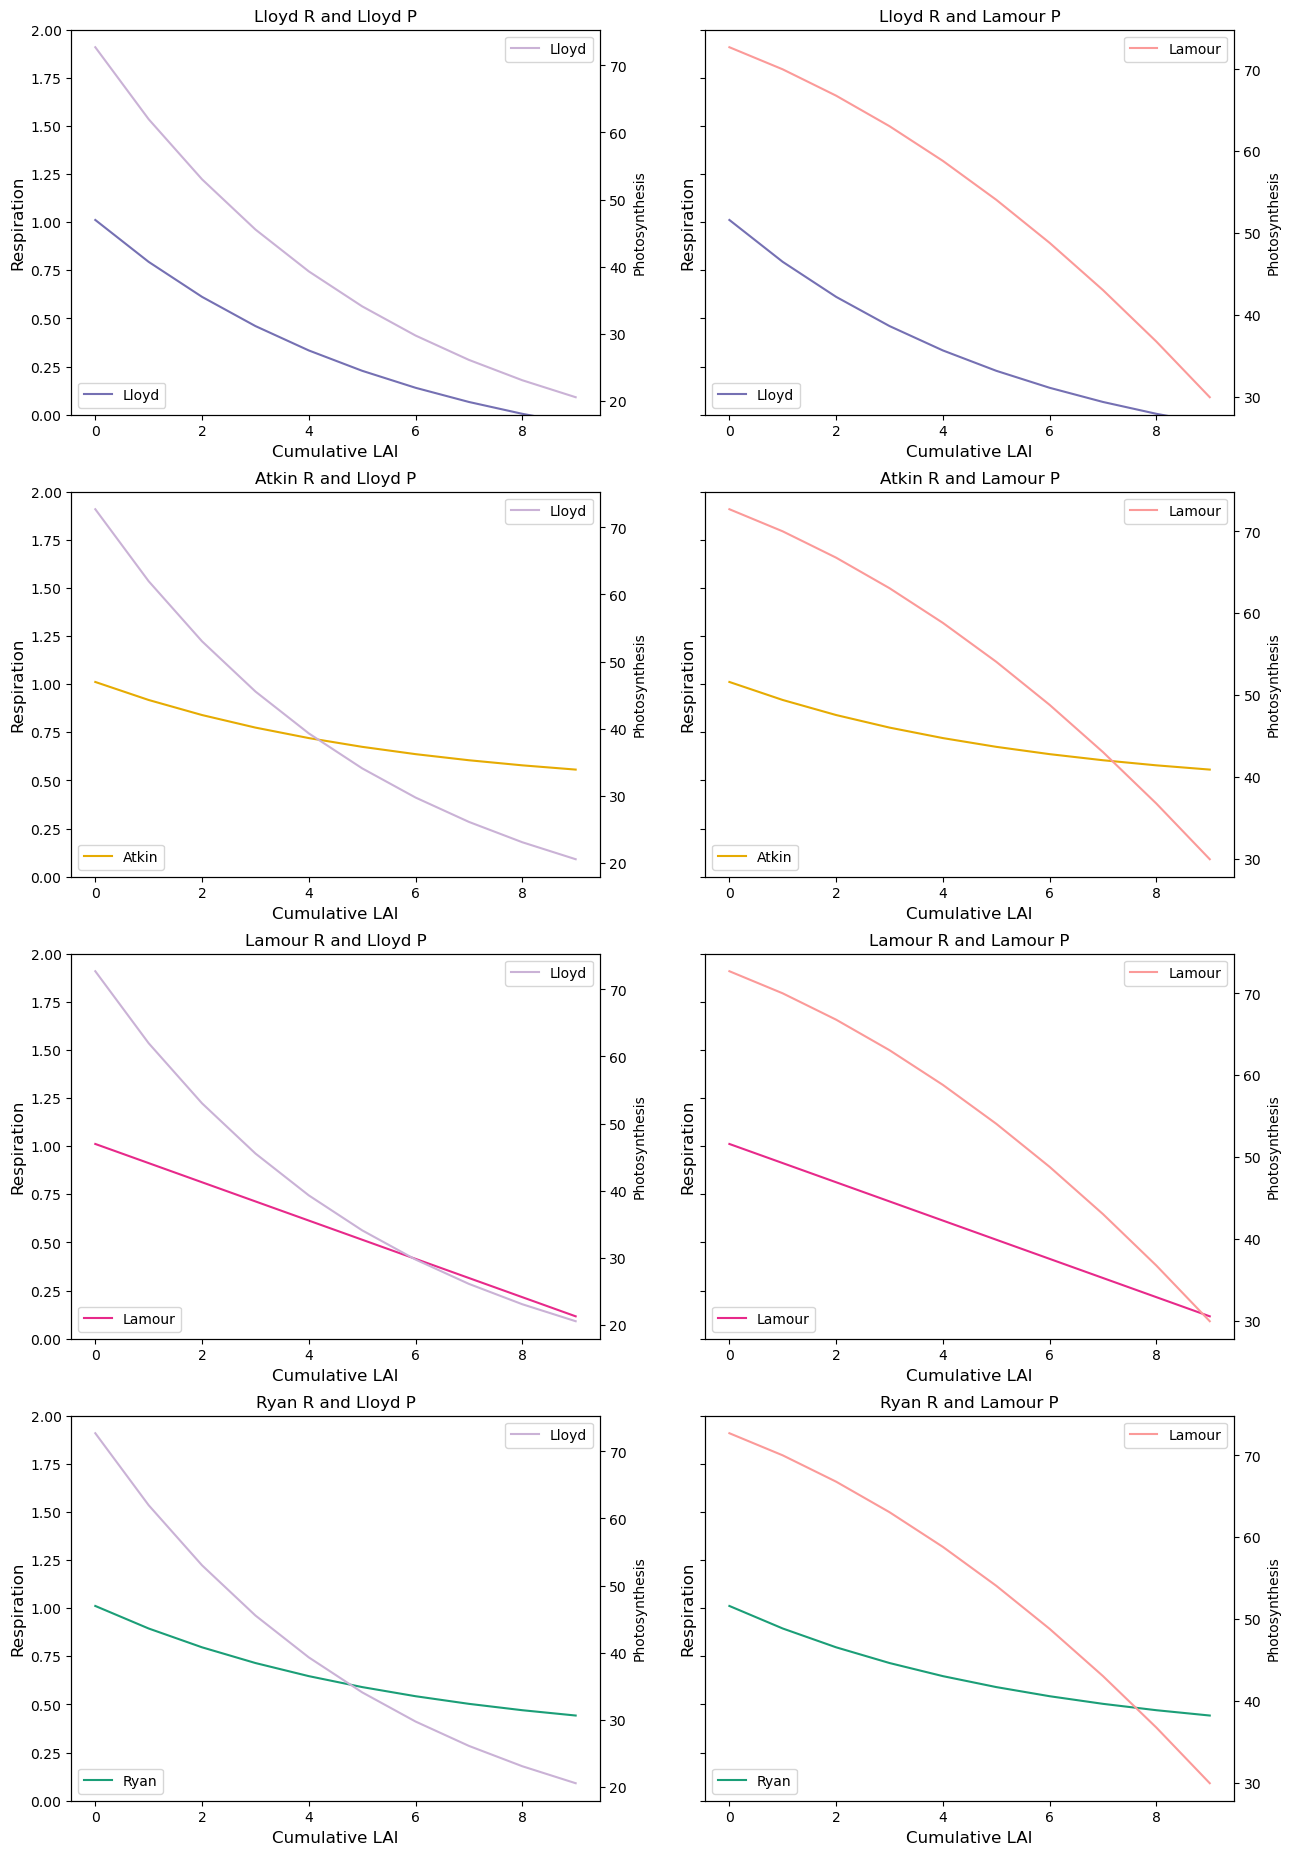

In [268]:
#photosynthesis schemes

#fates photosynthesis model
t_growth_celsius = 25
t_home_celsius = 25
tfrz = 273.15
veg_tempk = 298.15
rgas = 8314.4598
vcmaxha = (42.6 + (1.14*t_growth_celsius))*1e3
vcmaxhd = 200*1e3
vcmaxse = (645.13 - (0.38*t_growth_celsius))

vcmax25 = vcmax25top * nscaler_lloyd
vcmax = vcmax25 * 2**((veg_tempk-(tfrz+25))/10)
vcmax = vcmax / (1 + pow(math.e, (0.2*((tfrz+15)-veg_tempk))))
vcmax = vcmax / (1 + pow(math.e, (0.3*(veg_tempk-(tfrz+40)))))
vcmax_lloyd = vcmax

#julien's photosynthesis model
nscaler_lamour = 1.11894356 + (-0.0376549 * cumulative_lai) + (-0.00393463 * cumulative_lai**2)
vcmax25_lamour = vcmax25top * nscaler_lamour
vcmax_lamour = vcmax25_lamour * 2.**((veg_tempk - (tfrz + 25.)) / 10.)                                                                                         
vcmax_lamour = vcmax_lamour / (1. + np.exp( 0.2 * ((tfrz + 15.) - veg_tempk ) ))                                                                                  
vcmax_lamour = vcmax_lamour / (1. + np.exp( 0.3 * (veg_tempk - (tfrz + 40.)) ))

offset = vcmax_lamour[0] - vcmax_lloyd[0]

vcmax_lloyd = vcmax_lloyd + offset

fig1, ((f1ax0, f1ax1), (f1ax2, f1ax3), (f1ax4, f1ax5), (f1ax6, f1ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(15, 23), sharey=True)

#respiration curves
f1ax0.plot(cumulative_lai, lmr_lloyd, color=colormap2[3], label='Lloyd')
f1ax1.plot(cumulative_lai, lmr_lloyd, color=colormap2[3], label='Lloyd')
f1ax2.plot(cumulative_lai, lmr_atkin, color=colormap2[7], label='Atkin')
f1ax3.plot(cumulative_lai, lmr_atkin, color=colormap2[7], label='Atkin')
f1ax4.plot(cumulative_lai, lmr_lamour, color=colormap2[4], label='Lamour')
f1ax5.plot(cumulative_lai, lmr_lamour, color=colormap2[4], label='Lamour')
f1ax6.plot(cumulative_lai, lmr_ryan, color=colormap2[0], label='Ryan')
f1ax7.plot(cumulative_lai, lmr_ryan, color=colormap2[0], label='Ryan')

#photosynthesis curves
f1ax0a = f1ax0.twinx()
f1ax0a.plot(cumulative_lai, vcmax_lloyd, color=colormap[6], label='Lloyd')
f1ax1a = f1ax1.twinx()
f1ax1a.plot(cumulative_lai, vcmax_lamour, color=colormap[3], label='Lamour')
f1ax2a = f1ax2.twinx()
f1ax2a.plot(cumulative_lai, vcmax_lloyd, color=colormap[6], label='Lloyd')
f1ax3a = f1ax3.twinx()
f1ax3a.plot(cumulative_lai, vcmax_lamour, color=colormap[3], label='Lamour')
f1ax4a = f1ax4.twinx()
f1ax4a.plot(cumulative_lai, vcmax_lloyd, color=colormap[6], label='Lloyd')
f1ax5a = f1ax5.twinx()
f1ax5a.plot(cumulative_lai, vcmax_lamour, color=colormap[3], label='Lamour')
f1ax6a = f1ax6.twinx()
f1ax6a.plot(cumulative_lai, vcmax_lloyd, color=colormap[6], label='Lloyd')
f1ax7a = f1ax7.twinx()
f1ax7a.plot(cumulative_lai, vcmax_lamour, color=colormap[3], label='Lamour')

f1ax0.set_title(r'Lloyd R and Lloyd P', fontsize=12)
f1ax0.set_ylabel(r'Respiration', fontsize=12)
f1ax0.set_ylim(0, 2)
f1ax0a.set_ylabel(r'Photosynthesis')
f1ax0.set_xlabel(r'Cumulative LAI', fontsize=12)
f1ax0a.legend(loc="upper right")
f1ax0.legend(loc='lower left')

f1ax1.set_title(r'Lloyd R and Lamour P', fontsize=12)
f1ax1.set_ylabel(r'Respiration', fontsize=12)
f1ax1.set_ylim(0, 2)
f1ax1a.set_ylabel(r'Photosynthesis')
f1ax1.set_xlabel(r'Cumulative LAI', fontsize=12)
f1ax1a.legend(loc="upper right")
f1ax1.legend(loc='lower left')

f1ax2.set_title(r'Atkin R and Lloyd P', fontsize=12)
f1ax2.set_ylabel(r'Respiration', fontsize=12)
f1ax2.set_ylim(0, 2)
f1ax2a.set_ylabel(r'Photosynthesis')
f1ax2.set_xlabel(r'Cumulative LAI', fontsize=12)
f1ax2a.legend(loc="upper right")
f1ax2.legend(loc='lower left')

f1ax3.set_title(r'Atkin R and Lamour P', fontsize=12)
f1ax3.set_ylabel(r'Respiration', fontsize=12)
f1ax3.set_ylim(0, 2)
f1ax3a.set_ylabel(r'Photosynthesis')
f1ax3.set_xlabel(r'Cumulative LAI', fontsize=12)
f1ax3a.legend(loc="upper right")
f1ax3.legend(loc='lower left')

f1ax4.set_title(r'Lamour R and Lloyd P', fontsize=12)
f1ax4.set_ylabel(r'Respiration', fontsize=12)
f1ax4.set_ylim(0, 2)
f1ax4a.set_ylabel(r'Photosynthesis')
f1ax4.set_xlabel(r'Cumulative LAI', fontsize=12)
f1ax4a.legend(loc="upper right")
f1ax4.legend(loc='lower left')

f1ax5.set_title(r'Lamour R and Lamour P', fontsize=12)
f1ax5.set_ylabel(r'Respiration', fontsize=12)
f1ax5.set_ylim(0, 2)
f1ax5a.set_ylabel(r'Photosynthesis')
f1ax5.set_xlabel(r'Cumulative LAI', fontsize=12)
f1ax5a.legend(loc="upper right")
f1ax5.legend(loc='lower left')

f1ax6.set_title(r'Ryan R and Lloyd P', fontsize=12)
f1ax6.set_ylabel(r'Respiration', fontsize=12)
f1ax6.set_ylim(0, 2)
f1ax6a.set_ylabel(r'Photosynthesis')
f1ax6.set_xlabel(r'Cumulative LAI', fontsize=12)
f1ax6a.legend(loc="upper right")
f1ax6.legend(loc='lower left')

f1ax7.set_title(r'Ryan R and Lamour P', fontsize=12)
f1ax7.set_ylabel(r'Respiration', fontsize=12)
f1ax7.set_ylim(0, 2)
f1ax7a.set_ylabel(r'Photosynthesis')
f1ax7.set_xlabel(r'Cumulative LAI', fontsize=12)
f1ax7a.legend(loc="upper right")
f1ax7.legend(loc='lower left')

(8, 241)
('record', 'time')


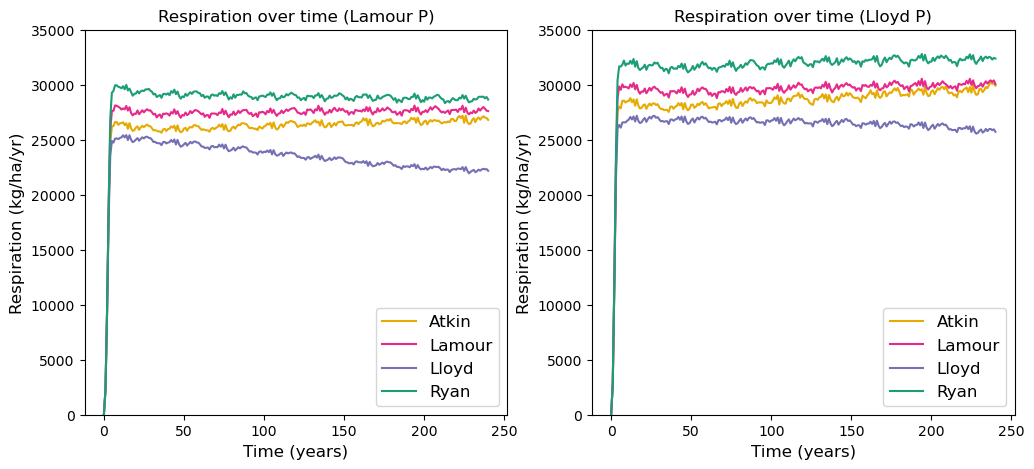

In [265]:
ninst = len(bcie3.variables['lon'])
bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

#respiration
resp = bcie3.FATES_AUTORESP_SZPF
#change from kg/m^2/s^1 to kg/ha/yr
resp = fa.scpf_to_scls_by_pft(resp, bcie3) * (10000) * (86400*365)
resp = np.squeeze(resp.sum(dim='fates_levpft'))
resp = np.squeeze(resp.sum(dim='fates_levscls'))

#crown area
ca = bcie3.FATES_CROWNAREA_PF
ca = np.squeeze(ca.sum(dim='fates_levpft')) * 10000 * (86400*365)

#mortality by carbon starvation
cstarv = bcie3.FATES_MORTALITY_CSTARV_SZPF
cstarv = fa.scpf_to_scls_by_pft(cstarv, bcie3)
cstarv = np.squeeze(cstarv.sum(dim='fates_levpft'))
cstarv = cstarv.isel(fates_levscls=slice(1,500))
cstarv = cstarv.mean(dim='time') * 10000
cstarv = cstarv/bcisw

#npp/gpp
npp = bcie3.FATES_NPP_PF * (10000 / 1000) * (86400*365)
npp = np.squeeze(npp.sum(dim='fates_levpft'))
gpp = bcie3.FATES_GPP_PF * (10000 / 1000) * (86400*365)
gpp = np.squeeze(gpp.sum(dim='fates_levpft'))
ngpp = npp/gpp

print(resp.shape)
print(resp.dims)

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

#respiration
#DOUBLE CHECK ORDER OF THE MODELS BEFORE PLOTTING
#Respiration with Lamour photosynthesis scaling scheme
f1ax0.plot(bcie3time, resp[0,:], color=colormap2[7], label='Atkin')
f1ax0.plot(bcie3time, resp[1,:], color=colormap2[4], label='Lamour')
f1ax0.plot(bcie3time, resp[2,:], color=colormap2[3], label='Lloyd')
f1ax0.plot(bcie3time, resp[3,:], color=colormap2[0], label='Ryan')
f1ax0.set_title(r'Respiration over time (Lamour P)', fontsize=12)
f1ax0.set_xlabel(r'Time (years)', fontsize=12)
f1ax0.set_ylabel(r'Respiration (kg/ha/yr)', fontsize=12)
f1ax0.set_ylim(0, 35000)
f1ax0.legend(prop={'size':12})

#Respiration with Lloyd photosynthesis scaling scheme
f1ax1.plot(bcie3time, resp[4,:], color=colormap2[7], label='Atkin')
f1ax1.plot(bcie3time, resp[5,:], color=colormap2[4], label='Lamour')
f1ax1.plot(bcie3time, resp[6,:], color=colormap2[3], label='Lloyd')
f1ax1.plot(bcie3time, resp[7,:], color=colormap2[0], label='Ryan')
f1ax1.set_title(r'Respiration over time (Lloyd P)', fontsize=12)
f1ax1.set_xlabel(r'Time (years)', fontsize=12)
f1ax1.set_ylabel(r'Respiration (kg/ha/yr)', fontsize=12)
f1ax1.set_ylim(0, 35000)
f1ax1.legend(prop={'size':12})

#crown area
"""f1ax1.plot(bcie3time, ca[0,:], color='green', label='atkin', alpha = 0.4)
f1ax1.plot(bcie3time, ca[1,:], color='orange', label='lamour', alpha = 0.4)
f1ax1.plot(bcie3time, ca[2,:], color='blue', label='concave', alpha = 0.4)
f1ax1.plot(bcie3time, ca[3,:], color='red', label='lloyd', alpha = 0.4)
f1ax1.set_title(r'Crown Area over time', fontsize=12)
f1ax1.set_xlabel(r'Time (years)', fontsize=12)
f1ax1.set_ylabel(r'Crown Area (m$^2$)', fontsize=12)
f1ax1.legend(prop={'size':12})"""

#mortality by carbon starvation
"""f1ax2.plot(cstarv[0,:].fates_levscls, cstarv[0,:], color='green', label='atkin', alpha = 0.4)
f1ax2.plot(cstarv[1,:].fates_levscls, cstarv[1,:], color='orange', label='lamour', alpha = 0.4)
f1ax2.plot(cstarv[2,:].fates_levscls, cstarv[2,:], color='blue', label='concave', alpha = 0.4)
f1ax2.plot(cstarv[3,:].fates_levscls, cstarv[3,:], color='red', label='lloyd', alpha = 0.4)
f1ax2.set_title(r'Carbon Starvation by Size', fontsize=12)
f1ax2.set_xlabel(r'Size (cm)', fontsize=12)
f1ax2.set_ylabel(r'Mortality by Carbon Starvation (m$^2$)', fontsize=12)
f1ax2.legend(prop={'size':12})
f1ax2.set_yscale('log')"""
           
#npp/gpp
f1ax3.plot(bcie3time, ngpp[0,:], color='green', label='atkin', alpha = 0.4)
f1ax3.plot(bcie3time, ngpp[1,:], color='orange', label='lamour', alpha = 0.4)
f1ax3.plot(bcie3time, ngpp[2,:], color='blue', label='concave', alpha = 0.4)
f1ax3.plot(bcie3time, ngpp[3,:], color='red', label='lloyd', alpha = 0.4)
f1ax3.set_title(r'NPP/GPP', fontsize=12)
f1ax3.set_xlabel(r'Time (years)', fontsize=12)
f1ax3.set_ylabel(r'NPP/GPP', fontsize=12)
f1ax3.legend(prop={'size':12})

#Does having a higher npp/gpp ratio mean that lloyd is the best for lai (more productivity)?
#Also potentially supported by crown area over time

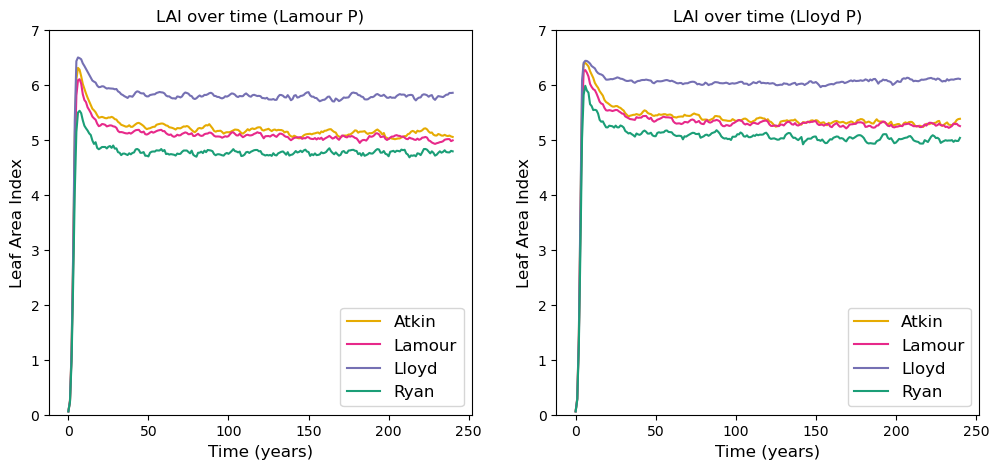

In [266]:
ninst = len(bcie3.variables['lon'])
bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

lai = bcie3.FATES_LAI

fig1, ((f1ax0, f1ax1)) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

f1ax0.plot(bcie3time, lai[0,:], color=colormap2[7], label='Atkin')
f1ax0.plot(bcie3time, lai[1,:], color=colormap2[4], label='Lamour')
f1ax0.plot(bcie3time, lai[2,:], color=colormap2[3], label='Lloyd')
f1ax0.plot(bcie3time, lai[3,:], color=colormap2[0], label='Ryan')
f1ax0.set_title(r'LAI over time (Lamour P)', fontsize=12)
f1ax0.set_xlabel(r'Time (years)', fontsize=12)
f1ax0.set_ylabel(r'Leaf Area Index', fontsize=12)
f1ax0.set_ylim(0, 7)
f1ax0.legend(prop={'size':12})

f1ax1.plot(bcie3time, lai[4,:], color=colormap2[7], label='Atkin')
f1ax1.plot(bcie3time, lai[5,:], color=colormap2[4], label='Lamour')
f1ax1.plot(bcie3time, lai[6,:], color=colormap2[3], label='Lloyd')
f1ax1.plot(bcie3time, lai[7,:], color=colormap2[0], label='Ryan')
f1ax1.set_title(r'LAI over time (Lloyd P)', fontsize=12)
f1ax1.set_xlabel(r'Time (years)', fontsize=12)
f1ax1.set_ylabel(r'Leaf Area Index', fontsize=12)
f1ax1.set_ylim(0, 7)
f1ax1.legend(prop={'size':12})

#Conclusion: all of our proposed models show lower lai than the original model

### Trimming

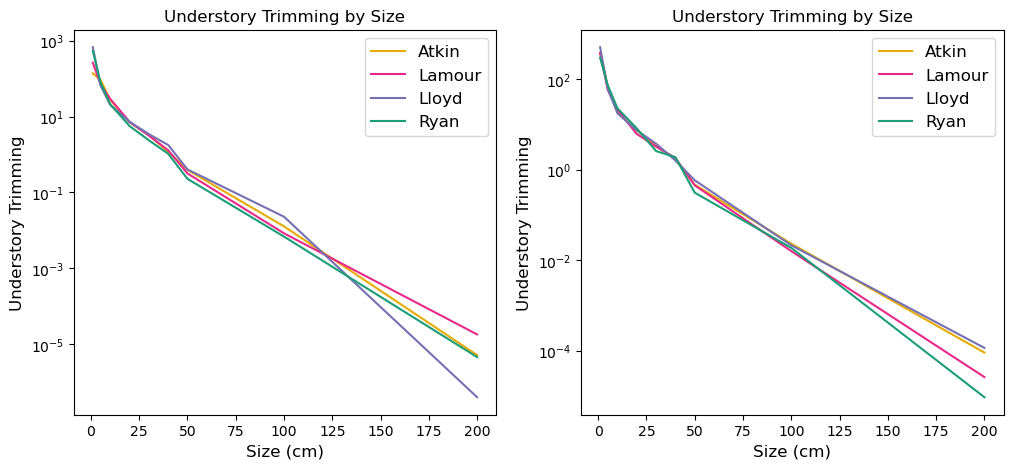

In [228]:
nyears = int(len(bcie3.variables['time']))
tave_start = nyears - 10
tave_stop  = nyears

bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

trimming = bcie3.FATES_TRIMMING_USTORY_SZ.isel(time=slice(tave_start, tave_stop))
trimming = trimming.isel(fates_levscls=slice(1,500))
trimming = np.squeeze(trimming.sum(dim='lndgrid'))
trimming = trimming.mean(dim='time') * 10000
trimming = trimming/bcisw

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 5))

f1ax0.plot(trimming.fates_levscls, trimming[0,:], label='Atkin', color=colormap2[7])
f1ax0.plot(trimming.fates_levscls, trimming[1,:], label='Lamour', color=colormap2[4])
f1ax0.plot(trimming.fates_levscls, trimming[2,:], label='Lloyd', color=colormap2[3])
f1ax0.plot(trimming.fates_levscls, trimming[3,:], label='Ryan', color=colormap2[0])
f1ax0.set_title(r'Understory Trimming by Size', fontsize=12)
f1ax0.set_xlabel(r'Size (cm)', fontsize=12)
f1ax0.set_ylabel(r'Understory Trimming', fontsize=12)
f1ax0.legend(prop={'size':12})
f1ax0.set_yscale('log')

f1ax1.plot(trimming.fates_levscls, trimming[4,:], label='Atkin', color=colormap2[7])
f1ax1.plot(trimming.fates_levscls, trimming[5,:], label='Lamour', color=colormap2[4])
f1ax1.plot(trimming.fates_levscls, trimming[6,:], label='Lloyd', color=colormap2[3])
f1ax1.plot(trimming.fates_levscls, trimming[7,:], label='Ryan', color=colormap2[0])
f1ax1.set_title(r'Understory Trimming by Size', fontsize=12)
f1ax1.set_xlabel(r'Size (cm)', fontsize=12)
f1ax1.set_ylabel(r'Understory Trimming', fontsize=12)
f1ax1.legend(prop={'size':12})
f1ax1.set_yscale('log')

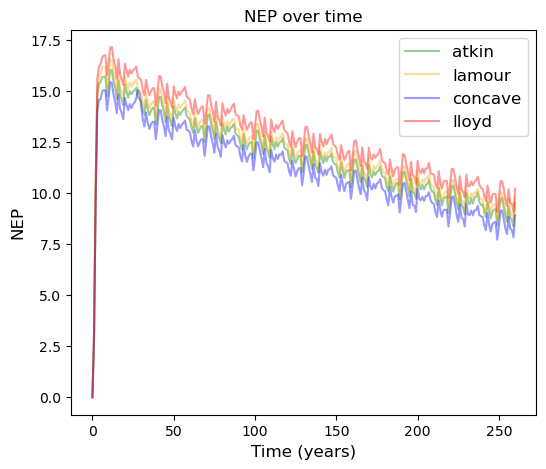

In [359]:
ninst = len(bcie3.variables['lon'])
bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

nep = bcie3.FATES_NEP * (10000 / 1000) * (86400*365)

fig1, ((f1ax0)) = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

f1ax0.plot(bcie3time, nep[0,:], color='green', label='atkin', alpha = 0.4)
f1ax0.plot(bcie3time, nep[1,:], color='orange', label='lamour', alpha = 0.4)
f1ax0.plot(bcie3time, nep[2,:], color='blue', label='concave', alpha = 0.4)
f1ax0.plot(bcie3time, nep[3,:], color='red', label='lloyd', alpha = 0.4)
f1ax0.set_title(r'NEP over time', fontsize=12)
f1ax0.set_xlabel(r'Time (years)', fontsize=12)
f1ax0.set_ylabel(r'NEP', fontsize=12)
f1ax0.legend(prop={'size':12})

### PFTs

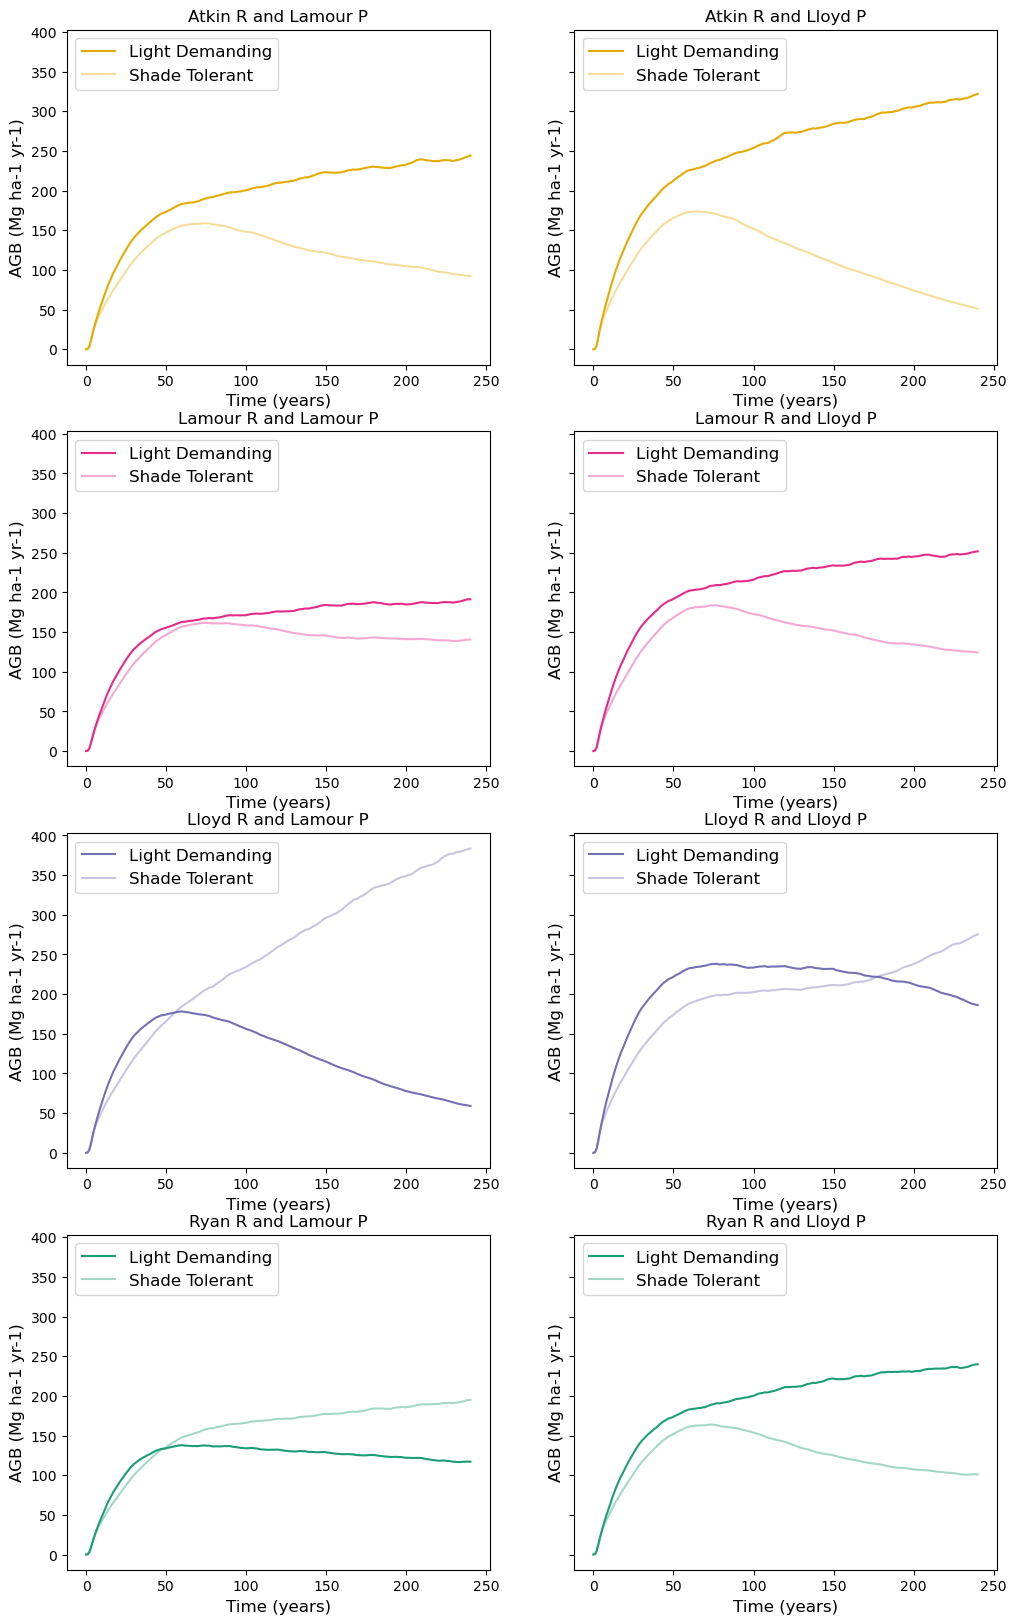

In [269]:
nyears = int(len(bcie.variables['time']))
tave_start = nyears - 10
tave_stop  = nyears

bcie_agb2 = bcie3.FATES_VEGC_PF * (10000 / 1000)
bcie_agb_ld2 = bcie_agb2.isel(fates_levpft=0)
bcie_agb_st2 = bcie_agb2.isel(fates_levpft=1)

#print(bcie_agb_ld[0,0]/bcie_agb[0])

fig1, ((f1ax0, f1ax1), (f1ax2, f1ax3), (f1ax4, f1ax5), (f1ax6, f1ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(12, 20), sharey=True)

#Atkin R Lamour P
f1ax0.plot(bcie3time, bcie_agb_ld2[0,:], label = 'Light Demanding', color=colormap2[7])
f1ax0.plot(bcie3time, bcie_agb_st2[0,:], label = 'Shade Tolerant', color=colormap2[7], alpha = 0.4)
f1ax0.set_xlabel(r'Time (years)', fontsize=12)
f1ax0.set_ylabel(r'AGB (Mg ha-1 yr-1)', fontsize=12)
f1ax0.set_title(r'Atkin R and Lamour P')
f1ax0.legend(prop={'size':12}, loc = "upper left")

#Atkin R Lamour P
f1ax1.plot(bcie3time, bcie_agb_ld2[4,:], label = 'Light Demanding', color=colormap2[7])
f1ax1.plot(bcie3time, bcie_agb_st2[4,:], label = 'Shade Tolerant', color=colormap2[7], alpha = 0.4)
f1ax1.set_xlabel(r'Time (years)', fontsize=12)
f1ax1.set_ylabel(r'AGB (Mg ha-1 yr-1)', fontsize=12)
f1ax1.set_title(r'Atkin R and Lloyd P')
f1ax1.legend(prop={'size':12}, loc = "upper left")

#Lamour R Lamour P
f1ax2.plot(bcie3time, bcie_agb_ld2[1,:], label='Light Demanding', color=colormap2[4])
f1ax2.plot(bcie3time, bcie_agb_st2[1,:], label='Shade Tolerant', color=colormap2[4], alpha=0.4)
f1ax2.set_xlabel(r'Time (years)', fontsize=12)
f1ax2.set_ylabel(r'AGB (Mg ha-1 yr-1)', fontsize=12)
f1ax2.set_title(r'Lamour R and Lamour P')
f1ax2.legend(prop={'size':12}, loc = "upper left")

#Lamour R Lamour P
f1ax3.plot(bcie3time, bcie_agb_ld2[5,:], label='Light Demanding', color=colormap2[4])
f1ax3.plot(bcie3time, bcie_agb_st2[5,:], label='Shade Tolerant', color=colormap2[4], alpha=0.4)
f1ax3.set_xlabel(r'Time (years)', fontsize=12)
f1ax3.set_ylabel(r'AGB (Mg ha-1 yr-1)', fontsize=12)
f1ax3.set_title(r'Lamour R and Lloyd P')
f1ax3.legend(prop={'size':12}, loc = "upper left")

#Lloyd R Lamour P
f1ax4.plot(bcie3time, bcie_agb_ld2[2,:], label='Light Demanding', color=colormap2[3])
f1ax4.plot(bcie3time, bcie_agb_st2[2,:], label='Shade Tolerant', color=colormap2[3], alpha=0.4)
f1ax4.set_xlabel(r'Time (years)', fontsize=12)
f1ax4.set_ylabel(r'AGB (Mg ha-1 yr-1)', fontsize=12)
f1ax4.set_title(r'Lloyd R and Lamour P')
f1ax4.legend(prop={'size':12}, loc = "upper left")

#Lloyd R Lamour P
f1ax5.plot(bcie3time, bcie_agb_ld2[6,:], label='Light Demanding', color=colormap2[3])
f1ax5.plot(bcie3time, bcie_agb_st2[6,:], label='Shade Tolerant', color=colormap2[3], alpha=0.4)
f1ax5.set_xlabel(r'Time (years)', fontsize=12)
f1ax5.set_ylabel(r'AGB (Mg ha-1 yr-1)', fontsize=12)
f1ax5.set_title(r'Lloyd R and Lloyd P')
f1ax5.legend(prop={'size':12}, loc = "upper left")

#Ryan R Lamour P
f1ax6.plot(bcie3time, bcie_agb_ld2[3,:], label='Light Demanding', color=colormap2[0])
f1ax6.plot(bcie3time, bcie_agb_st2[3,:], label='Shade Tolerant', color=colormap2[0], alpha=0.4)
f1ax6.set_xlabel(r'Time (years)', fontsize=12)
f1ax6.set_ylabel(r'AGB (Mg ha-1 yr-1)', fontsize=12)
f1ax6.set_title(r'Ryan R and Lamour P')
f1ax6.legend(prop={'size':12}, loc = "upper left")

#Ryan R Lamour P
f1ax7.plot(bcie3time, bcie_agb_ld2[7,:], label='Light Demanding', color=colormap2[0])
f1ax7.plot(bcie3time, bcie_agb_st2[7,:], label='Shade Tolerant', color=colormap2[0], alpha=0.4)
f1ax7.set_xlabel(r'Time (years)', fontsize=12)
f1ax7.set_ylabel(r'AGB (Mg ha-1 yr-1)', fontsize=12)
f1ax7.set_title(r'Ryan R and Lloyd P')
f1ax7.legend(prop={'size':12}, loc = "upper left")

### Photosynthesis vs Respiration

(8, 241)
('record', 'time')
(8,)
('record',)


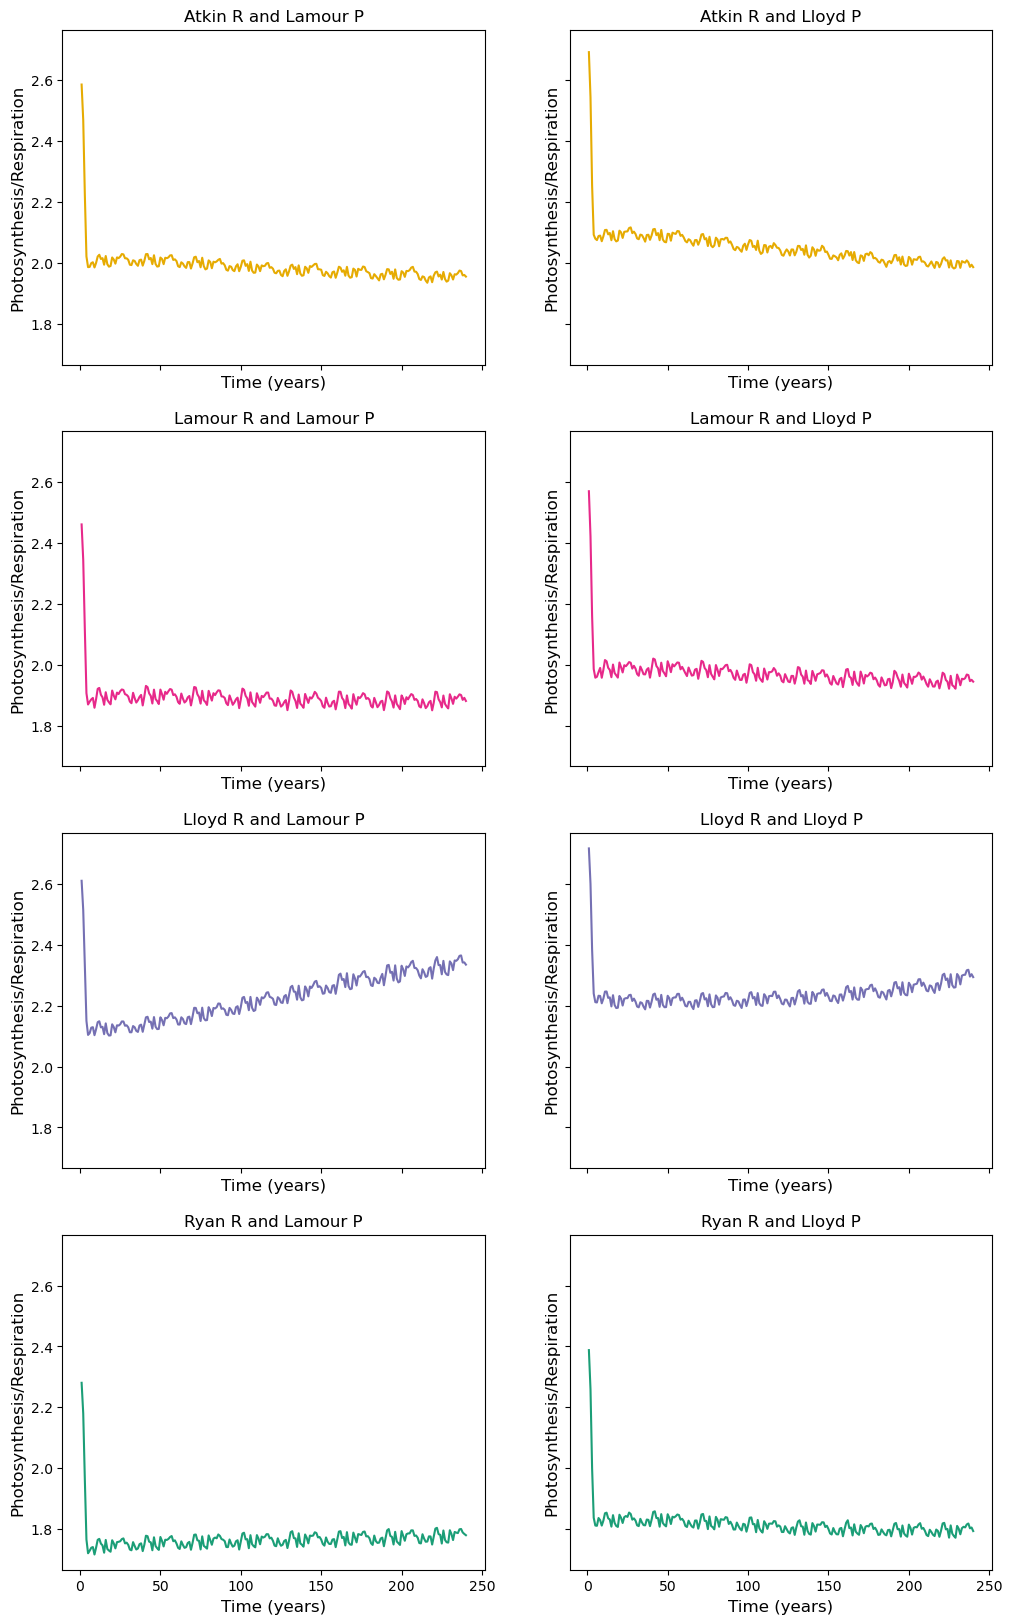

In [280]:
nyears = int(len(bcie.variables['time']))
tave_start = nyears - 50
tave_stop  = nyears

ps = bcie3.FATES_GPP_PF * (10000 / 1000) * (86400*365)
ps = np.squeeze(ps.sum(dim='fates_levpft'))
resp = bcie3.FATES_AUTORESP_SZPF
resp = fa.scpf_to_scls_by_pft(resp, bcie3) 
resp = resp * (10000 / 1000) * (86400*365)
resp = np.squeeze(resp.sum(dim='fates_levscls'))
resp = np.squeeze(resp.sum(dim='fates_levpft'))

ratio = ps/resp

fig1, ((f1ax0, f1ax1), (f1ax2, f1ax3), (f1ax4, f1ax5), (f1ax6, f1ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(12, 20), sharex=True, sharey=True)

#Atkin R and Lamour P
f1ax0.plot(bcie3time, ratio[0,:], color=colormap2[7])
f1ax0.set_xlabel(r'Time (years)', fontsize=12)
f1ax0.set_ylabel(r'Photosynthesis/Respiration', fontsize=12)
f1ax0.set_title(r'Atkin R and Lamour P')

#Atkin R and Lloyd P
f1ax1.plot(bcie3time, ratio[4,:], color=colormap2[7])
f1ax1.set_xlabel(r'Time (years)', fontsize=12)
f1ax1.set_ylabel(r'Photosynthesis/Respiration', fontsize=12)
f1ax1.set_title(r'Atkin R and Lloyd P')

#Lamour R and Lamour P
f1ax2.plot(bcie3time, ratio[1,:], color=colormap2[4])
f1ax2.set_xlabel(r'Time (years)', fontsize=12)
f1ax2.set_ylabel(r'Photosynthesis/Respiration', fontsize=12)
f1ax2.set_title(r'Lamour R and Lamour P')

#Lamour R and Lloyd P
f1ax3.plot(bcie3time, ratio[5,:], color=colormap2[4])
f1ax3.set_xlabel(r'Time (years)', fontsize=12)
f1ax3.set_ylabel(r'Photosynthesis/Respiration', fontsize=12)
f1ax3.set_title(r'Lamour R and Lloyd P')

#Lloyd R and Lamour P
f1ax4.plot(bcie3time, ratio[2,:], color=colormap2[3])
f1ax4.set_xlabel(r'Time (years)', fontsize=12)
f1ax4.set_ylabel(r'Photosynthesis/Respiration', fontsize=12)
f1ax4.set_title(r'Lloyd R and Lamour P')

#Lloyd R and Lloyd P
f1ax5.plot(bcie3time, ratio[6,:], color=colormap2[3])
f1ax5.set_xlabel(r'Time (years)', fontsize=12)
f1ax5.set_ylabel(r'Photosynthesis/Respiration', fontsize=12)
f1ax5.set_title(r'Lloyd R and Lloyd P')

#Ryan R and Lamour P
f1ax6.plot(bcie3time, ratio[3,:], color=colormap2[0])
f1ax6.set_xlabel(r'Time (years)', fontsize=12)
f1ax6.set_ylabel(r'Photosynthesis/Respiration', fontsize=12)
f1ax6.set_title(r'Ryan R and Lamour P')

#Ryan R and Lloyd P
f1ax7.plot(bcie3time, ratio[7,:], color=colormap2[0])
f1ax7.set_xlabel(r'Time (years)', fontsize=12)
f1ax7.set_ylabel(r'Photosynthesis/Respiration', fontsize=12)
f1ax7.set_title(r'Ryan R and Lloyd P')

print(ratio.shape)
print(ratio.dims)
ratio = ratio.isel(time=slice(tave_start, tave_stop))
ratio = ratio.mean(dim="time")
print(ratio.shape)
print(ratio.dims)

### Carbon Mortality by Size by Time

In [260]:
# #plants by size by yr
cstarv = bcie3.FATES_MORTALITY_CSTARV_SZPF
cstarv = fa.scpf_to_scls_by_pft(cstarv, bcie3)
cstarv = np.squeeze(cstarv.sum(dim='fates_levpft'))

numplant = bcie3.FATES_NPLANT_SZ
numplant = numplant.isel(time=slice(0,500), lndgrid=0)*10000

cstarv = cstarv/numplant

cohort_size_bins = bcie3.variables['fates_levscls'].values
cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[len(cohort_size_bins)-1]*1.5)

levels = np.array([0.1,0.3,1.,3.,10.,30., 100.,300.,1000., 3000., 10000.])
cmap = plt.get_cmap('Reds')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig1, ((f1ax0, f1ax1), (f1ax2, f1ax3), (f1ax4, f1ax5), (f1ax6, f1ax7)) = plt.subplots(nrows=4, ncols=2, figsize=(12, 20), sharex=True, sharey=True)

im0 = f1ax0.pcolormesh(bcie3time.isel(time=slice(0,240)), cohort_size_bins, (cstarv)[0,:].isel(time=slice(0,239)).transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im0, ax=f1ax0)
f1ax0.set_title(r'Carbon mortality by size by year (n ha$^{-1}$)')
f1ax0.set_xlabel('Time (yr)')
f1ax0.set_ylabel('Cohort Size (cm)')

im1 = f1ax1.pcolormesh(bcie3time.isel(time=slice(0,240)), cohort_size_bins, (cstarv)[1,:].isel(time=slice(0,239)).transpose(), cmap=cmap, norm=norm)
f1ax1.set_title(r'Carbon mortality by size by year (n ha$^{-1}$)')
f1ax1.set_xlabel('Time (yr)')
f1ax1.set_ylabel('Cohort Size (cm)')

im2 = f1ax2.pcolormesh(bcie3time.isel(time=slice(0,240)), cohort_size_bins, (cstarv)[2,:].isel(time=slice(0,239)).transpose(), cmap=cmap, norm=norm)
f1ax2.set_title(r'Carbon mortality by size by year (n ha$^{-1}$)')
f1ax2.set_xlabel('Time (yr)')
f1ax2.set_ylabel('Cohort Size (cm)')

im3 = f1ax3.pcolormesh(bcie3time.isel(time=slice(0,240)), cohort_size_bins, (cstarv)[3,:].isel(time=slice(0,239)).transpose(), cmap=cmap, norm=norm)
f1ax3.set_title(r'Carbon mortality by size by year (n ha$^{-1}$)')
f1ax3.set_xlabel('Time (yr)')
f1ax3.set_ylabel('Cohort Size (cm)')

im4 = f1ax4.pcolormesh(bcie3time.isel(time=slice(0,240)), cohort_size_bins, (cstarv)[4,:].isel(time=slice(0,239)).transpose(), cmap=cmap, norm=norm)
f1ax4.set_title(r'Carbon mortality by size by year (n ha$^{-1}$)')
f1ax4.set_xlabel('Time (yr)')
f1ax4.set_ylabel('Cohort Size (cm)')

im5 = f1ax5.pcolormesh(bcie3time.isel(time=slice(0,240)), cohort_size_bins, (cstarv)[5,:].isel(time=slice(0,239)).transpose(), cmap=cmap, norm=norm)
f1ax5.set_title(r'Carbon mortality by size by year (n ha$^{-1}$)')
f1ax5.set_xlabel('Time (yr)')
f1ax5.set_ylabel('Cohort Size (cm)')

im6 = f1ax6.pcolormesh(bcie3time.isel(time=slice(0,240)), cohort_size_bins, (cstarv)[6,:].isel(time=slice(0,239)).transpose(), cmap=cmap, norm=norm)
f1ax6.set_title(r'Carbon mortality by size by year (n ha$^{-1}$)')
f1ax6.set_xlabel('Time (yr)')
f1ax6.set_ylabel('Cohort Size (cm)')

im7 = f1ax7.pcolormesh(bcie3time.isel(time=slice(0,240)), cohort_size_bins, (cstarv)[7,:].isel(time=slice(0,239)).transpose(), cmap=cmap, norm=norm)
f1ax7.set_title(r'Carbon mortality by size by year (n ha$^{-1}$)')
f1ax7.set_xlabel('Time (yr)')
f1ax7.set_ylabel('Cohort Size (cm)')

AttributeError: 'DataArray' object has no attribute 'range'

### Ensemble Run AGB

3
3


''

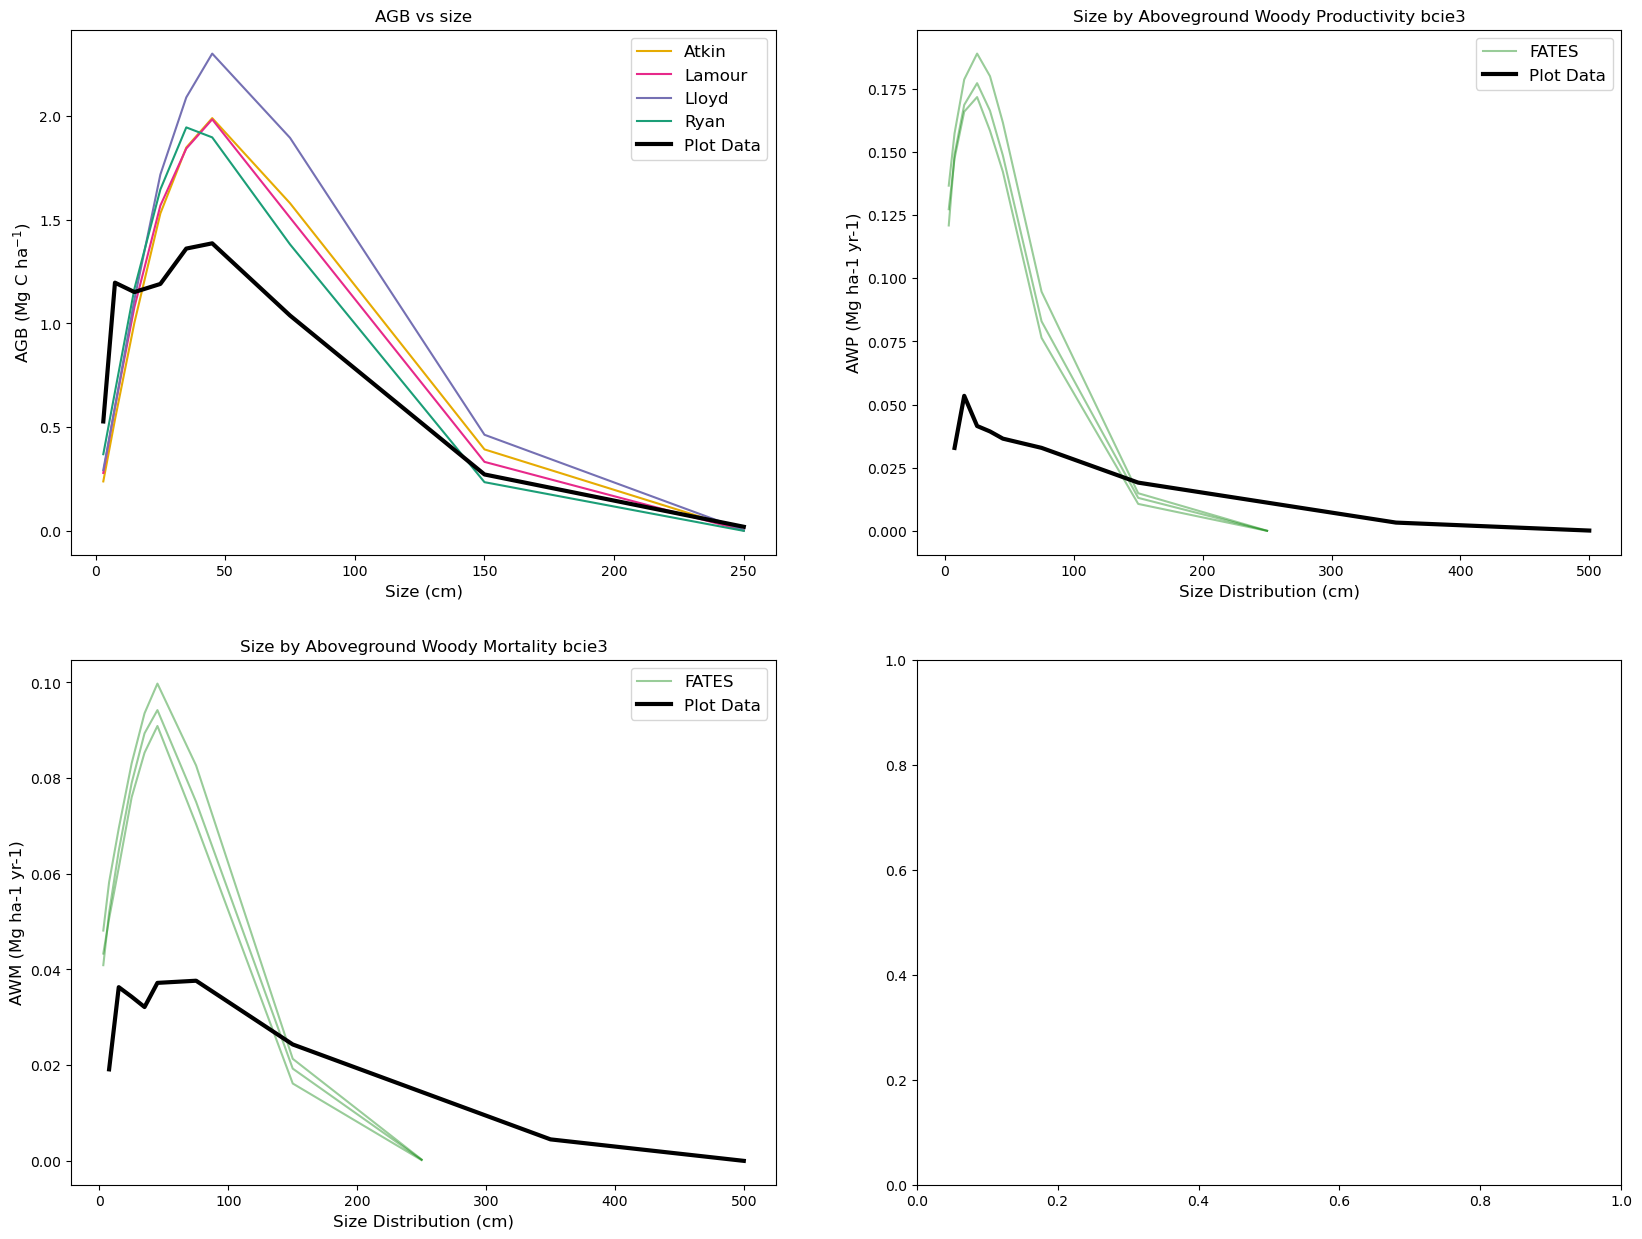

In [258]:
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#ensemble run agb 
ninst = len(bcie3.variables['lon'])

#defining time
nyears = int(len(bcie.variables['time']))
tave_start = 0
tave_stop  = nyears

#size class width bins for the piponiot data
scwidth = [4, 5, 10, 10, 10, 10, 50, 100, 300]
#size class width bins for the fates data
bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

AGB = bcie3.FATES_VEGC_ABOVEGROUND_SZPF
bci_agb = fa.scpf_to_scls_by_pft(AGB, bcie3)
bci_agb = np.squeeze(bci_agb.sum(dim='fates_levpft'))
bci_agb = bci_agb.isel(fates_levscls=slice(1,500))
bci_agb = bci_agb.mean(dim='time') * (10000 / 1000)

#aboveground woody productivity for old bcie
bci_awp = bcie3.FATES_ABOVEGROUND_PROD_SZPF 
bci_awp = fa.scpf_to_scls_by_pft(bci_awp, bcie3)
#summing over pft
bci_awp = np.squeeze(bci_awp.sum(dim='fates_levpft'))
#getting rid of the first size class to match piponiot data
bci_awp = bci_awp.isel(fates_levscls=slice(1,500))
# convert to kg ha-1 yr-1 from kg m-2 s-1
bci_awp = bci_awp.mean(dim='time') * (10000 / 1000) * (86400*365)

#aboveground woody mortality for new bcie3
bci_awm = bcie3.FATES_ABOVEGROUND_MORT_SZPF
bci_awm = fa.scpf_to_scls_by_pft(bci_awm, bcie3)
bci_awm = np.squeeze(bci_awm.sum(dim='fates_levpft'))
bci_awm = bci_awm.isel(fates_levscls=slice(1,500))
bci_awm = bci_awm.mean(dim='time') * (10000 / 1000) * (86400*365)

sclsbcie = bcie3.variables['fates_levscls'][:]
sclsbcie = np.append(sclsbcie[1:], 300)
sclsmidbcie = (sclsbcie[0:-1] + sclsbcie[1:])/2

#divide by the size bins
bci_awp = bci_awp / bcisw
bci_awm = bci_awm / bcisw
bci_agb = bci_agb / bcisw

fig1, ((f1ax0, f1ax1), (f2ax2, f2ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(20,15))
f1ax0.plot(sclsmidbcie, bci_agb[0,:], color=colormap2[7], label='Atkin')
f1ax0.plot(sclsmidbcie, bci_agb[1,:], color=colormap2[4], label='Lamour')
f1ax0.plot(sclsmidbcie, bci_agb[2,:], color=colormap2[3], label='Lloyd')
f1ax0.plot(sclsmidbcie, bci_agb[3,:], color=colormap2[0], label='Ryan')

#need to divide piponiot data by 2 because their biomass includes not just carbon and 
#fates biomass is only carbon.
f1ax0.plot(sclsmidbcie, pip_agb.total / scwidth / 2, color='black', 
           label = 'Plot Data', linewidth = 3)
f1ax0.set_title(r'AGB vs size', fontsize = 12)
f1ax0.set_ylabel(r'AGB (Mg C ha$^{-1}$)', fontsize = 12)
f1ax0.set_xlabel(r'Size (cm)', fontsize = 12)
f1ax0.legend(prop={'size':12})

for  i in range(0,3):
    if i == 0: 
        f1ax1.plot(sclsmidbcie, bci_awp[i,:], color='green', 
                  label = 'FATES', alpha = 0.4)
        f2ax2.plot(sclsmidbcie, bci_awm[i,:], color='green', 
                  label = 'FATES', alpha = 0.4)
    else:
        f1ax1.plot(sclsmidbcie, bci_awp[i,:], color='green', alpha = 0.4)
        f2ax2.plot(sclsmidbcie, bci_awm[i,:], color='green', alpha = 0.4)

#Aboveground woody productivity for new bcie2
f1ax1.plot(sclsmidpip, pip_awp.total / scwidth / 2, color='black', 
           label = 'Plot Data', linewidth = 3)
f1ax1.set_title(r'Size by Aboveground Woody Productivity bcie3', fontsize=12)
f1ax1.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax1.set_ylabel(r'AWP (Mg ha-1 yr-1)', fontsize=12)
f1ax1.legend(prop={'size':12})

#Aboveground woody mortality for new bcie 2
f2ax2.plot(sclsmidpip, pip_awm.total / scwidth / 2, color='black', 
           label = 'Plot Data', linewidth = 3)
f2ax2.set_title(r'Size by Aboveground Woody Mortality bcie3', fontsize=12)
f2ax2.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f2ax2.set_ylabel(r'AWM (Mg ha-1 yr-1)', fontsize=12)
f2ax2.legend(prop={'size':12})

#RMSE from Jessica for AWP
rmse_sizedist1 = []
for i in range(0,4):
    rmse_sizedist1.append(rmse(pip_awp.total / scwidth / 2, bci_awp[i,:]))
    
sizedist_best1 = rmse_sizedist1.index(min(rmse_sizedist1)) 
print(sizedist_best1)

#RMSE for AWM
rmse_sizedist2 = []
for i in range(0,4):
    rmse_sizedist2.append(rmse(pip_awm.total / scwidth / 2, bci_awm[i,:]))
    
sizedist_best2 = rmse_sizedist2.index(min(rmse_sizedist2)) 
print(sizedist_best2)
;

#CONCLUSIONS: concave is the best fit for both awp and awm for both ensemble runs

#CONCLUSIONS: Lloyd has the most biomass (original model), then Lamour, full Atkin, concave. 
#It makes sense that Lloyd and concave have opposite reactions because they are the most different
#from each other. All of the curves are greatly underestimating biomass

2
2


''

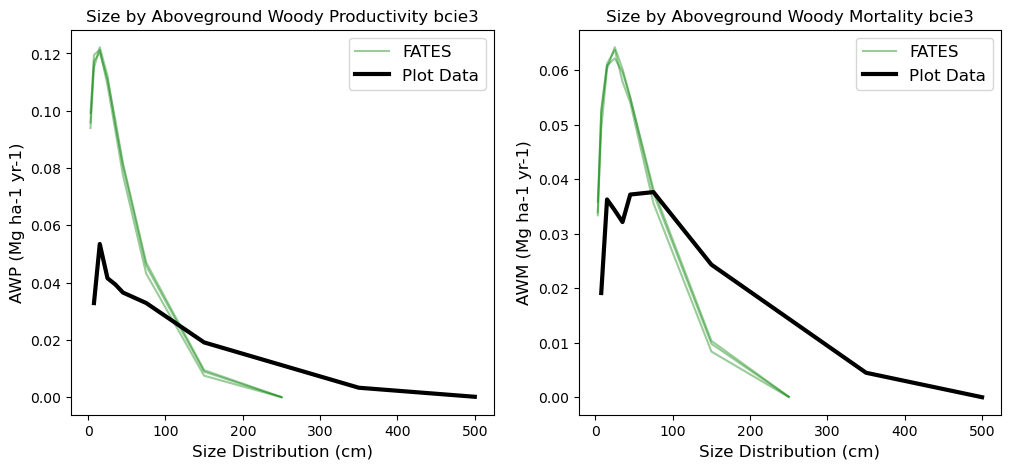

In [370]:
#first FATES ensemble run at BCI (301 years) vs second FATES ensemble run at BCI ()
#pretty good fit for awp and slightly less good fit for awm

#Jessica's rmse definition
def rmse(predictions, targets):
    return np.sqrt(((predictions - targets) ** 2).mean())

#defining time
nyears = int(len(bcie.variables['time']))
tave_start = 0
tave_stop  = nyears

#size class width bins for the piponiot data
scwidth = [4, 5, 10, 10, 10, 10, 50, 100, 300]
#size class width bins for the fates data
bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

sclsbcie = bcie3.variables['fates_levscls'][:]
sclsbcie = np.append(sclsbcie[1:], 300)
sclsmidbcie = (sclsbcie[0:-1] + sclsbcie[1:])/2

sclspip = pip_agb.size_class.astype(float)
sclspip = np.append(sclspip[0:], 500)
sclsmidpip = (sclspip[0:-1] + sclspip[1:])/2

#aboveground woody productivity for old bcie
bci_awp = bcie.FATES_ABOVEGROUND_PROD_SZPF 
bci_awp = fa.scpf_to_scls_by_pft(bci_awp, bcie)
#summing over pft
bci_awp = np.squeeze(bci_awp.sum(dim='fates_levpft'))
#getting rid of the first size class to match piponiot data
bci_awp = bci_awp.isel(fates_levscls=slice(1,500))
# convert to kg ha-1 yr-1 from kg m-2 s-1
bci_awp = bci_awp.mean(dim='time') * (10000 / 1000) * (86400*365)

#aboveground woody productivity for new bcie3
bci_awp3 = bcie3.FATES_ABOVEGROUND_PROD_SZPF
bci_awp3 = fa.scpf_to_scls_by_pft(bci_awp3, bcie3)
bci_awp3 = np.squeeze(bci_awp3.sum(dim='fates_levpft'))
bci_awp3 = bci_awp3.isel(fates_levscls=slice(1,500))
bci_awp3 = bci_awp3.mean(dim='time') * (10000 / 1000) * (86400*365)

#aboveground woody mortality for old bcie
bci_awm = bcie.FATES_ABOVEGROUND_MORT_SZPF
bci_awm = fa.scpf_to_scls_by_pft(bci_awm, bcie)
bci_awm = np.squeeze(bci_awm.sum(dim='fates_levpft'))
bci_awm = bci_awm.isel(fates_levscls=slice(1,500))
bci_awm = bci_awm.mean(dim='time') * (10000 / 1000) * (86400*365)

#aboveground woody mortality for new bcie3
bci_awm3 = bcie3.FATES_ABOVEGROUND_MORT_SZPF
bci_awm3 = fa.scpf_to_scls_by_pft(bci_awm3, bcie3)
bci_awm3 = np.squeeze(bci_awm3.sum(dim='fates_levpft'))
bci_awm3 = bci_awm3.isel(fates_levscls=slice(1,500))
bci_awm3 = bci_awm3.mean(dim='time') * (10000 / 1000) * (86400*365)

#divide by the size bins
bci_awp = bci_awp / bcisw
bci_awm = bci_awm / bcisw
bci_awp3 = bci_awp3 / bcisw
bci_awm3 = bci_awm3 / bcisw

#PLOT
fig2, ((f2ax2, f2ax3)) = plt.subplots(nrows=1,ncols=2, figsize=(12,5))

for  i in range(0,3):
    if i == 0: 
        #f2ax0.plot(sclsmidbcie, bci_awp[i,:], color='green', 
        #          label = 'FATES', alpha = 0.4)
        #f2ax1.plot(sclsmidbcie, bci_awm[i,:], color='green', 
        #          label = 'FATES', alpha = 0.4)
        f2ax2.plot(sclsmidbcie, bci_awp3[i,:], color='green', 
                  label = 'FATES', alpha = 0.4)
        f2ax3.plot(sclsmidbcie, bci_awm3[i,:], color='green', 
                  label = 'FATES', alpha = 0.4)
    else: 
        #f2ax0.plot(sclsmidbcie, bci_awp[i,:], color='green', alpha = 0.4)
        #f2ax1.plot(sclsmidbcie, bci_awm[i,:], color='green', alpha = 0.4)
        f2ax2.plot(sclsmidbcie, bci_awp3[i,:], color='green', alpha = 0.4)
        f2ax3.plot(sclsmidbcie, bci_awm3[i,:], color='green', alpha = 0.4)

#Aboveground woody productivity for old bcie
"""f2ax0.plot(sclsmidpip, pip_awp.total / scwidth / 2, color='black', 
           label = 'Plot Data', linewidth = 3)        
f2ax0.set_title(r'Size by Aboveground Woody Productivity bcie1', fontsize=12)
f2ax0.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f2ax0.set_ylabel(r'AWP (Mg ha-1 yr-1)', fontsize=12)
f2ax0.legend(prop={'size':12})

#Aboveground woody mortality for old bcie
f2ax1.plot(sclsmidpip, pip_awm.total / scwidth / 2, color='black', 
           label = 'Plot Data', linewidth = 3)
f2ax1.set_title(r'Size by Aboveground Woody Mortality bcie1', fontsize=12)
f2ax1.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f2ax1.set_ylabel(r'AWM (Mg ha-1 yr-1)', fontsize=12)
f2ax1.legend(prop={'size':12})"""

#Aboveground woody productivity for new bcie2
f2ax2.plot(sclsmidpip, pip_awp.total / scwidth / 2, color='black', 
           label = 'Plot Data', linewidth = 3)
f2ax2.set_title(r'Size by Aboveground Woody Productivity bcie3', fontsize=12)
f2ax2.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f2ax2.set_ylabel(r'AWP (Mg ha-1 yr-1)', fontsize=12)
f2ax2.legend(prop={'size':12})

#Aboveground woody mortality for new bcie 2
f2ax3.plot(sclsmidpip, pip_awm.total / scwidth / 2, color='black', 
           label = 'Plot Data', linewidth = 3)
f2ax3.set_title(r'Size by Aboveground Woody Mortality bcie3', fontsize=12)
f2ax3.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f2ax3.set_ylabel(r'AWM (Mg ha-1 yr-1)', fontsize=12)
f2ax3.legend(prop={'size':12})

#RMSE from Jessica for AWP
rmse_sizedist1 = []
for i in range(0,4):
    rmse_sizedist1.append(rmse(pip_awp.total / scwidth / 2, bci_awp3[i,:]))
    
sizedist_best1 = rmse_sizedist1.index(min(rmse_sizedist1)) 
print(sizedist_best1)

#RMSE for AWM
rmse_sizedist2 = []
for i in range(0,4):
    rmse_sizedist2.append(rmse(pip_awm.total / scwidth / 2, bci_awm3[i,:]))
    
sizedist_best2 = rmse_sizedist2.index(min(rmse_sizedist2)) 
print(sizedist_best2)
;

#CONCLUSIONS: concave is the best fit for both awp and awm for both ensemble runs

### Net Carbon Uptake by Leaf Layer

(4, 3, 36)
('record', 'fates_levcan', 'fates_levleaf')


(0.0, 10.0)

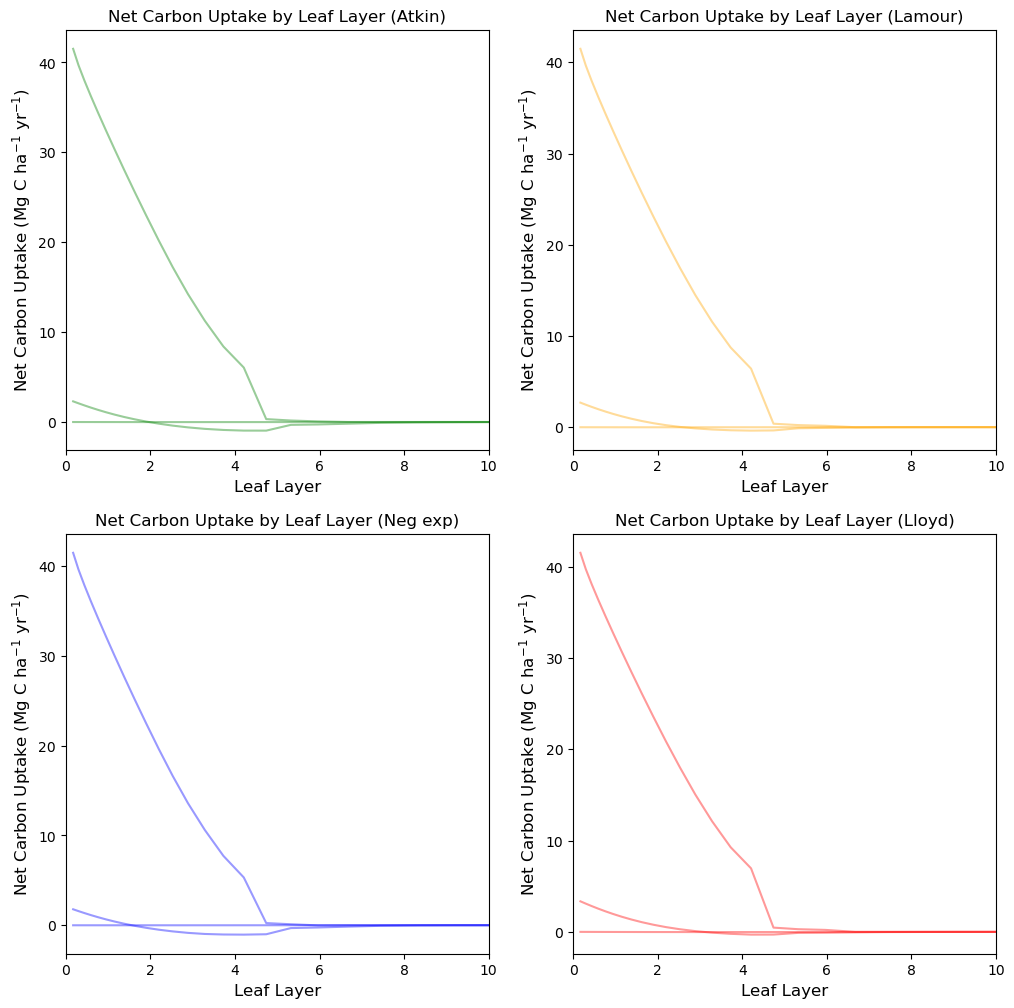

In [373]:
#number of plants by size by year

nyears = int(len(bcie3.variables['time']))

vai_top_bin_width = 0.1
vai_width_increase_factor = 1.1
nlevleaf = 37 # it is actually 36 but do 37 here to get midpoints
z = np.linspace(1,nlevleaf,nlevleaf)
dinc_vai = vai_top_bin_width * vai_width_increase_factor ** z
cumulative_lais = np.cumsum(dinc_vai)

lower = cumulative_lais[0:-1]
upper = cumulative_lais[1:]
leaf_layer_mids = (lower + upper)*0.5

# make a dataset that has a fates_levleaf dimension
data = np.arange(36)
locs = leaf_layer_mids
dataset2 = xr.DataArray(data, coords={'fates_levleaf':locs}, dims = 'fates_levleaf')
# untangle all the dimensions  - this variable is in kg C m-2 s-1 (per ground area NOT leaf area)
netc = bcie3.FATES_NET_C_UPTAKE_CLLLPF
netc = clllpf_to_cn_lf_by_pft(netc, bcie3, dataset2) 
netc = np.squeeze(netc.sum(dim='fates_levpft'))
netc = netc.mean(dim='time') * 10000 / 1000 * (86400*365)

print(netc.shape)
print(netc.dims)

#bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

#netc = netc/bcisw

fig1, ((f1ax0, f1ax1), (f1ax2, f1ax3)) = plt.subplots(nrows=2,ncols=2, figsize=(12,12))

for  i in range(0,3):
    f1ax0.plot(netc.fates_levleaf, netc[0,i,:], color='green',
                   label='atkin', alpha = 0.4)
    f1ax1.plot(netc.fates_levleaf, netc[1,i,:], color='orange',
                   label='lamour', alpha = 0.4)
    f1ax2.plot(netc.fates_levleaf, netc[2,i,:], color='blue',
                   label='concave', alpha=0.4)
    f1ax3.plot(netc.fates_levleaf, netc[3,i,:], color='red',
                   label='lloyd', alpha=0.4)
    '''else: 
        for j in range(0,2):
            f1ax0.plot(netc.fates_levleaf, netc[0,j,:], color='green',
                   label='atkin', alpha = 0.4)
            f1ax1.plot(netc.fates_levleaf, netc[1,j,:], color='orange',
                   label='lamour', alpha = 0.4)
            f1ax2.plot(netc.fates_levleaf, netc[2,j,:], color='blue',
                   label='concave', alpha=0.4)
            f1ax3.plot(netc.fates_levleaf, netc[3,j,:], color='red',
                   label='lloyd', alpha=0.4)'''


f1ax0.set_title(r'Net Carbon Uptake by Leaf Layer (Atkin)', fontsize = 12)
f1ax0.set_ylabel(r'Net Carbon Uptake (Mg C ha$^{-1}$ yr$^{-1}$)', fontsize = 12)
f1ax0.set_xlabel(r'Leaf Layer', fontsize = 12)
f1ax0.set_xlim(0,10)

f1ax1.set_title(r'Net Carbon Uptake by Leaf Layer (Lamour)', fontsize = 12)
f1ax1.set_ylabel(r'Net Carbon Uptake (Mg C ha$^{-1}$ yr$^{-1}$)', fontsize = 12)
f1ax1.set_xlabel(r'Leaf Layer', fontsize = 12)
f1ax1.set_xlim(0,10)

f1ax2.set_title(r'Net Carbon Uptake by Leaf Layer (Neg exp)', fontsize = 12)
f1ax2.set_ylabel(r'Net Carbon Uptake (Mg C ha$^{-1}$ yr$^{-1}$)', fontsize = 12)
f1ax2.set_xlabel(r'Leaf Layer', fontsize = 12)
f1ax2.set_xlim(0,10)

f1ax3.set_title(r'Net Carbon Uptake by Leaf Layer (Lloyd)', fontsize = 12)
f1ax3.set_ylabel(r'Net Carbon Uptake (Mg C ha$^{-1}$ yr$^{-1}$)', fontsize = 12)
f1ax3.set_xlabel(r'Leaf Layer', fontsize = 12)
f1ax3.set_xlim(0,10)

### Number of Plants by Size by Year

(0.0, 400.0)

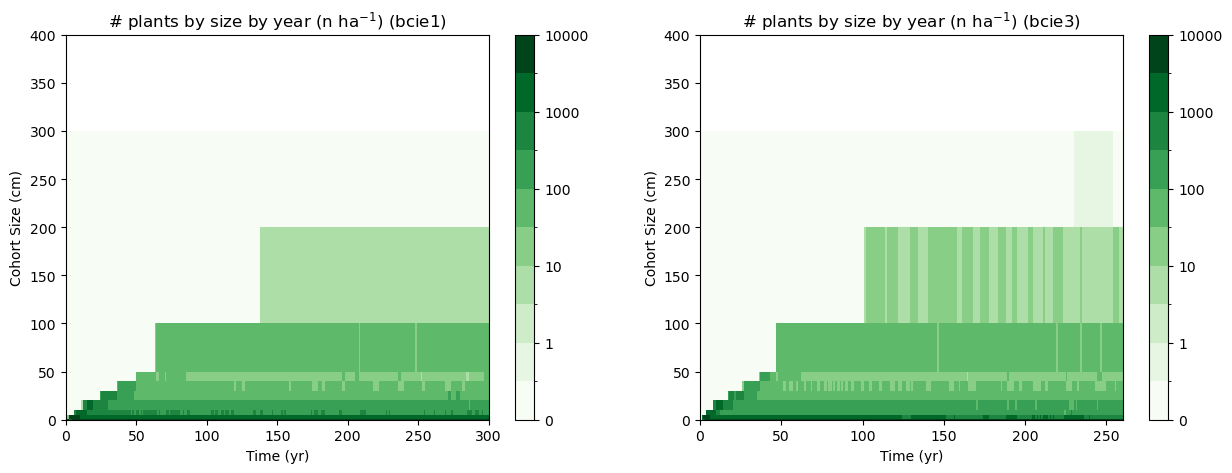

In [375]:
# #plants by size by yr
numplant = bcie.FATES_NPLANT_SZ
numplant3 = bcie3.FATES_NPLANT_SZ
numplant = numplant.isel(time=slice(0,300))*10000
numplant3 = numplant3.isel(time=slice(0,260))*10000

cohort_size_bins = bcie.variables['fates_levscls'].values
cohort_size_bins = np.append(cohort_size_bins,cohort_size_bins[len(cohort_size_bins)-1]*1.5)

levels = np.array([0.1,0.3,1.,3.,10.,30., 100.,300.,1000., 3000., 10000.])
cmap = plt.get_cmap('Greens')
norm = BoundaryNorm(levels, ncolors=cmap.N, clip=True)

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))

im = f1ax0.pcolormesh(bcietime, cohort_size_bins, (numplant)[1,:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im, ax=f1ax0)
f1ax0.set_title(r'# plants by size by year (n ha$^{-1}$) (bcie1)')
f1ax0.set_xlabel('Time (yr)')
f1ax0.set_ylabel('Cohort Size (cm)')
f1ax0.set_ylim(0, 400)

im2 = f1ax1.pcolormesh(bcie3time, cohort_size_bins, (numplant3)[1,:,:,0].transpose(), cmap=cmap, norm=norm)
fig1.colorbar(im2, ax=f1ax1)
f1ax1.set_title(r'# plants by size by year (n ha$^{-1}$) (bcie3)')
f1ax1.set_xlabel('Time (yr)')
f1ax1.set_ylabel('Cohort Size (cm)')

plt.ylim([0, 400])

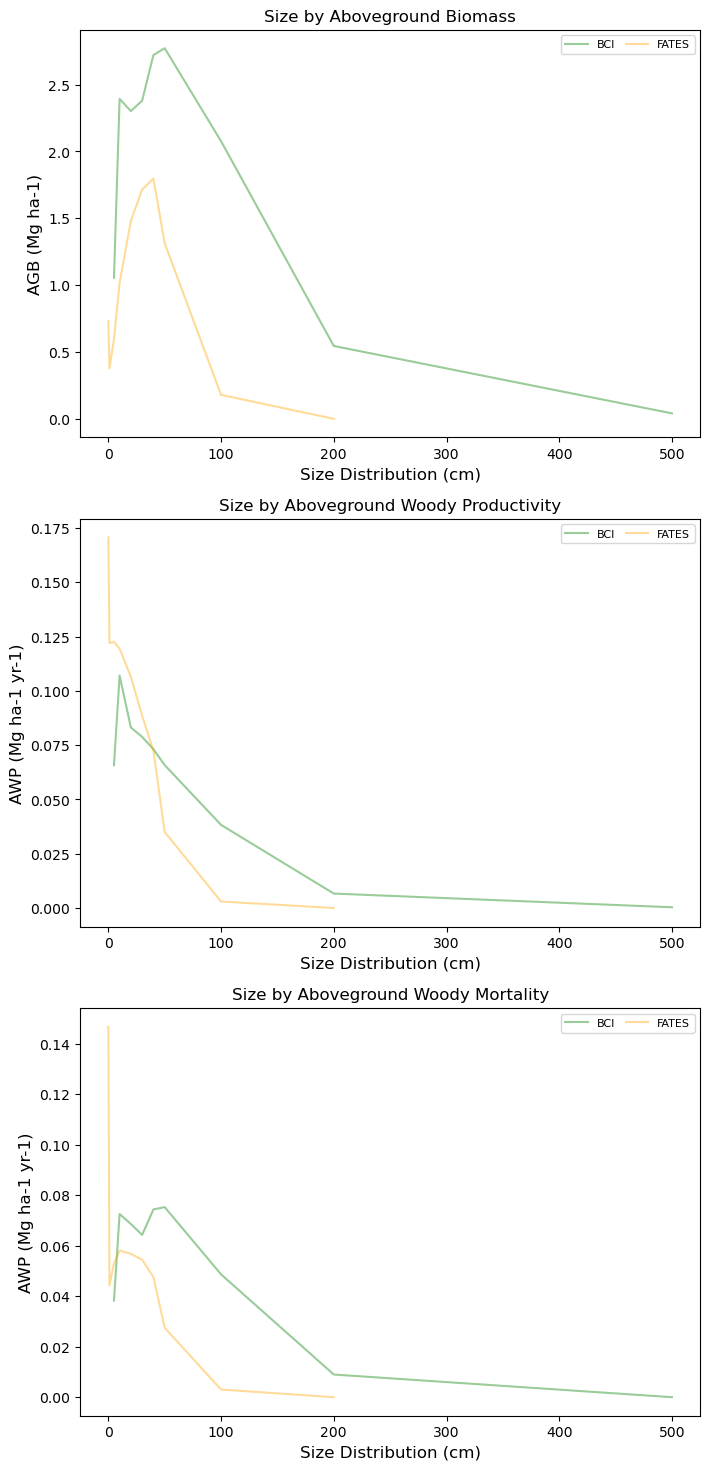

In [32]:
#TESTING VERY FIRST BCI RUN AGAINST PIPONIOT DATA -- OUTDATED
#pip in megagrams need to multiply by 1000 to go from Mg to kg


#creating bins for 
scbins = [1, 5, 10, 20, 30, 40, 50, 100, 200, 500]
scwidth = [4, 5, 10, 10, 10, 10, 50, 100, 300]

bci_agb = bci1.FATES_VEGC_ABOVEGROUND_SZ
bci_agb = bci_agb.mean(dim='time') * 10000 / 1000

bcisc = [0, 1, 5, 10, 20, 30, 40, 50, 100, 200, 500]
bcisw = [1, 4, 5, 10, 10, 10, 10, 50, 100, 300]

adjusted = np.squeeze(bci_agb)/bcisw

bci_awp = bci1.FATES_ABOVEGROUND_PROD_SZPF
bci_awp = fa.scpf_to_scls_by_pft(bci_awp, bci1)
bci_awp = bci_awp.mean(dim='time') * 10000 / 1000 * (86400*365)

bci_awm = bci1.FATES_ABOVEGROUND_MORT_SZPF
bci_awm = fa.scpf_to_scls_by_pft(bci_awm, bci1)
bci_awm = bci_awm.mean(dim='time') * 10000 / 1000 * (86400*365)

fig1, (f1ax0, f1ax1, f1ax2) = plt.subplots(nrows=3, ncols=1, figsize=(8, 18))

f1ax0.plot(pip_agb.size_class.astype(float), np.squeeze(pip_agb.total) / scwidth, 
           color='green', label='BCI', alpha=0.4)
f1ax0.plot(bci_agb.fates_levscls, adjusted, color='orange', label='FATES', alpha=0.4)
f1ax0.set_title(r'Size by Aboveground Biomass', fontsize=12)
f1ax0.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax0.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)
f1ax0.legend(loc='upper right', ncols=4, fontsize = 8, columnspacing = 1, alignment='right')

f1ax1.plot(pip_awp.size_class.astype(float), pip_awp.total / scwidth, color='green', label='BCI', alpha=0.4)
f1ax1.plot(bci_awp.fates_levscls, bci_awp.sel(lndgrid = 0).sel(fates_levpft = 1) / bcisw, 
           color='orange', label='FATES', alpha=0.4)
f1ax1.set_title(r'Size by Aboveground Woody Productivity', fontsize=12)
f1ax1.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax1.set_ylabel(r'AWP (Mg ha-1 yr-1)', fontsize=12)
f1ax1.legend(loc='upper right', ncols=4, fontsize = 8, columnspacing = 1, alignment='right')

f1ax2.plot(pip_awm.size_class.astype(float), pip_awm.total / scwidth, color='green', label='BCI', alpha=0.4)
f1ax2.plot(bci_awm.fates_levscls, bci_awm.sel(fates_levpft = 1).sel(lndgrid = 0) / bcisw, 
           color='orange', label='FATES', alpha=0.4)
f1ax2.set_title(r'Size by Aboveground Woody Mortality', fontsize=12)
f1ax2.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax2.set_ylabel(r'AWP (Mg ha-1 yr-1)', fontsize=12)
f1ax2.legend(loc='upper right', ncols=4, fontsize = 8, columnspacing = 1, alignment='right')

### BCI Model Run plots

<xarray.DataArray 'fates_levscls' (fates_levscls: 10)>
array([  0.,   1.,   5.,  10.,  20.,  30.,  40.,  50., 100., 200.],
      dtype=float32)
Coordinates:
  * fates_levscls  (fates_levscls) float32 0.0 1.0 5.0 10.0 ... 50.0 100.0 200.0
Attributes:
    long_name:  FATES diameter size class lower bound
    units:      cm


Text(0, 0.5, 'Mortality rate due to Carbon Starvation (ha-1 yr-1)')

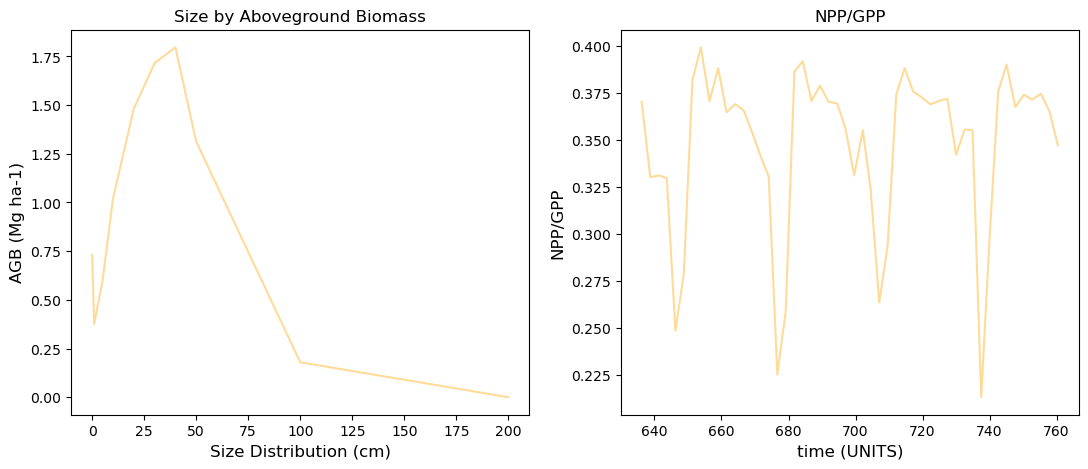

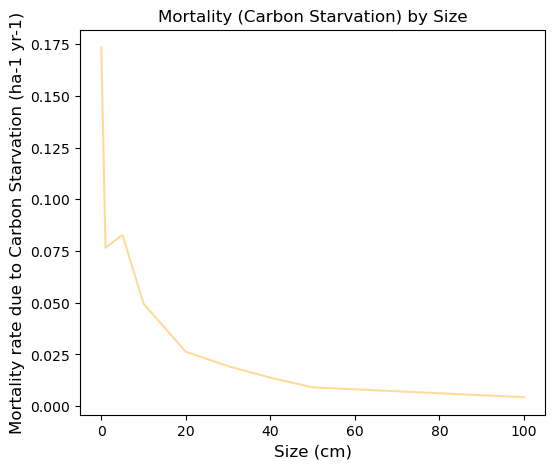

In [5]:
#kg m-2 s-1 -> Mg ha-1 yr-1
#print(bci_agb.fates_levscls)
bci_agb = bci1.FATES_VEGC_ABOVEGROUND_SZ
bci_agb = bci_agb.mean(dim='time') * 10000 / 1000

bcisc = [0, 1, 5, 10, 20, 30, 40, 50, 100, 200, 500]
bcisw = [1, 4, 5, 10, 10, 10, 10, 50, 100, 300]

adjusted = np.squeeze(bci_agb)/bcisw

nyears = int(len(bci1.variables['time'])/12)
tave_start = (nyears-50)
tave_stop  = nyears

bci_npp = bci1.FATES_NPP/(86400*365)
bci_gpp = bci1.FATES_GPP/(86400*365)
bci_npp = (bci1.FATES_NPP).isel(time=slice(tave_start, tave_stop))
bci_gpp = (bci1.FATES_GPP).isel(time=slice(tave_start, tave_stop))

ngpp = bci_npp/bci_gpp

bci_cstarv = bci1.FATES_MORTALITY_CSTARV_SZ * 10000
bci_cstarv = bci_cstarv.mean(dim='time')

print(bci_cstarv.fates_levscls)

bci_pop = bci1.FATES_NPLANT_SZ * 10000
bci_pop = bci_pop.mean(dim='time')

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

#Biomass
f1ax0.plot(bci_agb.fates_levscls, adjusted, color='orange', label='FATES', alpha=0.4)
f1ax0.set_title(r'Size by Aboveground Biomass', fontsize=12)
f1ax0.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax0.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)

f1ax1.plot(bci1time, ngpp, color="orange", alpha=0.4)
f1ax1.set_title(r'NPP/GPP', fontsize=12)
f1ax1.set_xlabel(r'time (UNITS)', fontsize=12)
f1ax1.set_ylabel(r'NPP/GPP', fontsize=12)

fig2, (f2ax0) = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

f2ax0.plot(bci_cstarv.fates_levscls, bci_cstarv/bci_pop, color='orange', alpha=0.4)
f2ax0.set_title(r'Mortality (Carbon Starvation) by Size', fontsize=12)
f2ax0.set_xlabel(r'Size (cm)', fontsize=12)
f2ax0.set_ylabel(r'Mortality rate due to Carbon Starvation (ha-1 yr-1)', fontsize=12)

<xarray.DataArray 'fates_levscls' (fates_levscls: 10)>
array([  0.,   1.,   5.,  10.,  20.,  30.,  40.,  50., 100., 200.],
      dtype=float32)
Coordinates:
  * fates_levscls  (fates_levscls) float32 0.0 1.0 5.0 10.0 ... 50.0 100.0 200.0
Attributes:
    long_name:  FATES diameter size class lower bound
    units:      cm


Text(0, 0.5, 'Mortality rate due to Carbon Starvation (ha-1 yr-1)')

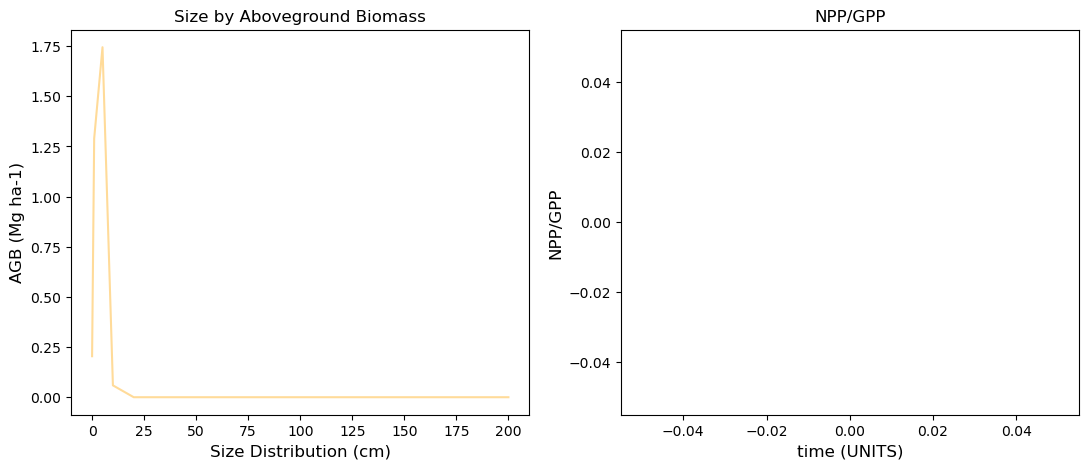

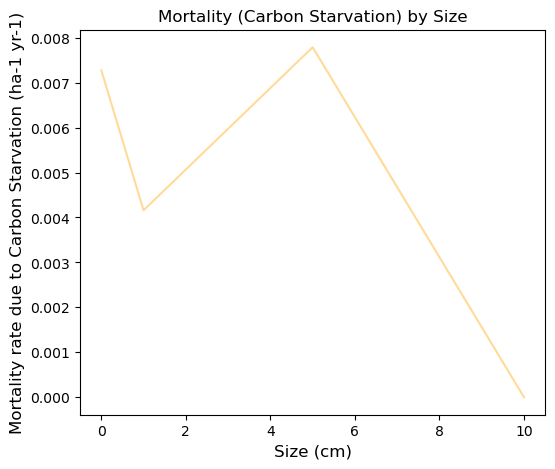

In [6]:
bci_agb = bci2.FATES_VEGC_ABOVEGROUND_SZ
bci_agb = bci_agb.mean(dim='time') * 10000 / 1000

bcisc = [0, 1, 5, 10, 20, 30, 40, 50, 100, 200, 500]
bcisw = [1, 4, 5, 10, 10, 10, 10, 50, 100, 300]

adjusted = np.squeeze(bci_agb)/bcisw

nyears = int(len(bci2.variables['time'])/12)
tave_start = (nyears-50)
tave_stop  = nyears

bci_npp = bci2.FATES_NPP/(86400*365)
bci_gpp = bci2.FATES_GPP/(86400*365)
bci_npp = (bci2.FATES_NPP).isel(time=slice(tave_start, tave_stop))
bci_gpp = (bci2.FATES_GPP).isel(time=slice(tave_start, tave_stop))

ngpp = bci_npp/bci_gpp

bci_cstarv = bci2.FATES_MORTALITY_CSTARV_SZ * 10000
bci_cstarv = bci_cstarv.mean(dim='time')

print(bci_cstarv.fates_levscls)

bci_pop = bci2.FATES_NPLANT_SZ * 10000
bci_pop = bci_pop.mean(dim='time')

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(13, 5))

#Biomass
f1ax0.plot(bci_agb.fates_levscls, adjusted, color='orange', label='FATES', alpha=0.4)
f1ax0.set_title(r'Size by Aboveground Biomass', fontsize=12)
f1ax0.set_xlabel(r'Size Distribution (cm)', fontsize=12)
f1ax0.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)

f1ax1.plot(bci2time, ngpp, color="orange", alpha=0.4)
f1ax1.set_title(r'NPP/GPP', fontsize=12)
f1ax1.set_xlabel(r'time (UNITS)', fontsize=12)
f1ax1.set_ylabel(r'NPP/GPP', fontsize=12)

fig2, (f2ax0) = plt.subplots(nrows=1, ncols=1, figsize=(6, 5))

f2ax0.plot(bci_cstarv.fates_levscls, bci_cstarv/bci_pop, color='orange', alpha=0.4)
f2ax0.set_title(r'Mortality (Carbon Starvation) by Size', fontsize=12)
f2ax0.set_xlabel(r'Size (cm)', fontsize=12)
f2ax0.set_ylabel(r'Mortality rate due to Carbon Starvation (ha-1 yr-1)', fontsize=12)

ValueError: Data must be 1-dimensional

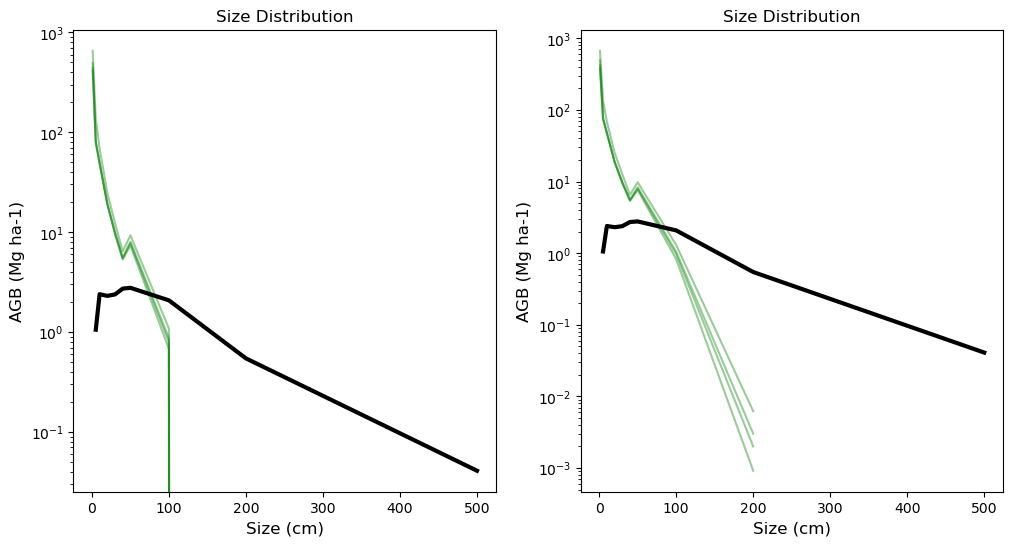

In [56]:
#pip in megagrams need to multiply by 1000 to go from Mg to kg
scwidth = [4, 5, 10, 10, 10, 10, 50, 100, 300]
bcisw = [4, 5, 10, 10, 10, 10, 50, 100, 300]

bcie_np = bcie.FATES_NPLANT_SZ
bcie_np = bcie_np.isel(fates_levscls=slice(1,500))
bcie_np = bcie_np.mean(dim='time')* 10000

bcie_np3 = bcie3.FATES_NPLANT_SZ
bcie_np3 = bcie_np3.isel(fates_levscls=slice(1,500))
bcie_np3 = bcie_np3.mean(dim='time') * 10000

bcie_np = bcie_np/bcisw
bcie_np3 = bcie_np3/bcisw

fig1, (f1ax0, f1ax1) = plt.subplots(nrows=1, ncols=2, figsize=(12, 6))

for  i in range(0,4):
    if i == 0: 
        f1ax0.plot(bcie_np.fates_levscls, bcie_np[i,:,0], color='green', 
                  label = 'FATES', alpha = 0.4)
        f1ax1.plot(bcie_np3.fates_levscls, bcie_np3[i,:,0], color='green',
                  label = 'FATES', alpha = 0.4)
    else: 
        f1ax0.plot(bcie_np.fates_levscls, bcie_np[i,:,0], color='green', alpha = 0.4)
        f1ax1.plot(bcie_np3.fates_levscls, bcie_np3[i,:,0], color='green', alpha = 0.4)

f1ax0.plot(pip_agb.size_class.astype(float), np.squeeze(pip_agb.total) / scwidth, 
           color='black', label='BCI', linewidth = 3)
f1ax0.set_title(r'Size Distribution', fontsize=12)
f1ax0.set_xlabel(r'Size (cm)', fontsize=12)
f1ax0.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)
f1ax0.set_yscale('log')

f1ax1.plot(pip_agb.size_class.astype(float), np.squeeze(pip_agb.total) / scwidth, 
           color='black', label='BCI', linewidth = 3)
f1ax1.set_title(r'Size Distribution', fontsize=12)
f1ax1.set_xlabel(r'Size (cm)', fontsize=12)
f1ax1.set_ylabel(r'AGB (Mg ha-1)', fontsize=12)
f1ax1.set_yscale('log')

#RMSE
rmse_sizedist = []
for i in range(0,4):
    rmse_sizedist.append(rmse(pip_agb.total / scwidth, bcie_np3[i,:]))
    
sizedist_best = rmse_sizedist.index(min(rmse_sizedist)) 
print(sizedist_best)